# PHÂN TÍCH CHẤT LƯỢNG RƯỢU

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

## Bảng phân công công việc

## Phát biểu bài toán

## Giới thiệu về dữ liệu

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)
library(MLmetrics)
library(pls)
library(gridExtra)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
response_variable = 1 

# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}


metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
     hist(model$residuals, breaks = 30)
     shaptest <- shapiro.test(model$residuals)
     print(shaptest)
     if (shaptest$p.value <= 0.05) {
          print("H0 rejected: the residuals are NOT distributed normally")
     } else {
          print("H0 failed to reject: the residuals ARE distributed normally")
     }
}

CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
wine_red <- read.table("../../data/part2/wine+quality/winequality-red.csv", header=TRUE, sep=";", stringsAsFactors = FALSE)
wine_white <- read.table("../../data/part2/wine+quality/winequality-white.csv", header=TRUE, sep=";", stringsAsFactors = FALSE)

wine_red$color <- 'red'
wine_white$color <- 'white'

raw_data <- bind_rows(wine_red, wine_white)


head(raw_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 4898 dòng và 12 cột
dim(raw_data)

[1] 6497   13

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [5]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- (raw_data[duplicated(raw_data), ])
length(duplicates)

[1] 13

In [6]:
clean_data <- unique(raw_data)

In [7]:
duplicates <- clean_data[duplicated(clean_data), ]
if (nrow(duplicates) == 0) {
  print("No duplicates found. Data is clean.")
} else {
  print("Duplicates still exist:")
  print(duplicates)
}

dim(raw_data)
dim(clean_data)

[1] "No duplicates found. Data is clean."


[1] 6497   13

[1] 5320   13

### Mỗi cột mang ý nghĩa gì?

In [8]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	6497 obs. of  13 variables:
 $ fixed.acidity       : num  7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile.acidity    : num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid         : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar      : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num  0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free.sulfur.dioxide : num  11 25 15 17 11 13 15 15 9 17 ...
 $ total.sulfur.dioxide: num  34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num  0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num  3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num  0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num  9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : int  5 5 5 6 5 5 5 7 7 5 ...
 $ color               : chr  "red" "red" "red" "red" ...


Dưới đây là mô tả chi tiết về các đặc trưng trong bộ dữ liệu này:

| Tên biến             | Vai trò   | Kiểu     | Mô tả                                             | Đơn vị | Giá trị bị thiếu |
| -------------------- | --------- | -------- | ------------------------------------------------- | ------ | ---------------- |
| fixed_acidity        | Đặc trưng | Liên tục | Độ axit cố định (hầu hết là axit tartaric)        | g/dm³  | Không            |
| volatile_acidity     | Đặc trưng | Liên tục | Độ axit bay hơi (chủ yếu là axit acetic)          | g/dm³  | Không            |
| citric_acid          | Đặc trưng | Liên tục | Hàm lượng axit citric                             | g/dm³  | Không            |
| residual_sugar       | Đặc trưng | Liên tục | Lượng đường còn lại sau khi lên men               | g/dm³  | Không            |
| chlorides            | Đặc trưng | Liên tục | Lượng muối                                        | g/dm³  | Không            |
| free_sulfur_dioxide  | Đặc trưng | Liên tục | Lượng SO2 tự do                                   | mg/dm³ | Không            |
| total_sulfur_dioxide | Đặc trưng | Liên tục | Tổng lượng SO2                                    | mg/dm³ | Không            |
| density              | Đặc trưng | Liên tục | Mật độ của rượu                                   | g/cm³  | Không            |
| pH                   | Đặc trưng | Liên tục | Độ pH của rượu                                    |        | Không            |
| sulphates            | Đặc trưng | Liên tục | Lượng muối sunphat                                | g/dm³  | Không            |
| alcohol              | Đặc trưng | Liên tục | Phần trăm cồn trong rượu                          | %      | Không            |
| quality              | Mục tiêu  | Nguyên   | Điểm chất lượng của rượu (thang điểm từ 0 đến 10) |        | Không            |


### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [9]:
wine_quality <- raw_data

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [10]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [11]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(wine_quality) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(wine_quality) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable             missing   min lower median upper     max
   <chr>                  <dbl> <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1 fixed.acidity              0 3.8     6.4    7     7.7  15.9  
 2 volatile.acidity           0 0.08    0.2    0.3   0.4   1.58 
 3 citric.acid                0 0       0.2    0.3   0.4   1.66 
 4 residual.sugar             0 0.6     1.8    3     8.1  65.8  
 5 chlorides                  0 0.009   0      0     0.1   0.611
 6 free.sulfur.dioxide        0 1      17     29    41   289    
 7 total.sulfur.dioxide       0 6      77    118   156   440    
 8 density                    0 0.987   1      1     1     1.04 
 9 pH                         0 2.72    3.1    3.2   3.3   4.01 
10 sulphates                  0 0.22    0.4    0.5   0.6   2    
11 alcohol                    0 8       9.5   10.3  11.3  14.9  
12 quality                    0 3       5      6     6     9    


In [12]:
print(summary(as.data.frame(wine_quality) %>% select_if(is.numeric)))

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.400   1st Qu.:0.2300   1st Qu.:0.2500   1st Qu.: 1.800  
 Median : 7.000   Median :0.2900   Median :0.3100   Median : 3.000  
 Mean   : 7.215   Mean   :0.3397   Mean   :0.3186   Mean   : 5.443  
 3rd Qu.: 7.700   3rd Qu.:0.4000   3rd Qu.:0.3900   3rd Qu.: 8.100  
 Max.   :15.900   Max.   :1.5800   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  1.00      Min.   :  6.0        Min.   :0.9871  
 1st Qu.:0.03800   1st Qu.: 17.00      1st Qu.: 77.0        1st Qu.:0.9923  
 Median :0.04700   Median : 29.00      Median :118.0        Median :0.9949  
 Mean   :0.05603   Mean   : 30.53      Mean   :115.7        Mean   :0.9947  
 3rd Qu.:0.06500   3rd Qu.: 41.00      3rd Qu.:156.0        3rd Qu.:0.9970  
 Max.   :0.61100   Max.   :289.00      Max.   :440.0   

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Không có cột nào có kiểu dữ liệu phân loại

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [13]:
names(wine_quality)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "quality"             
[13] "color"

### Khảo sát chất lượng rượu

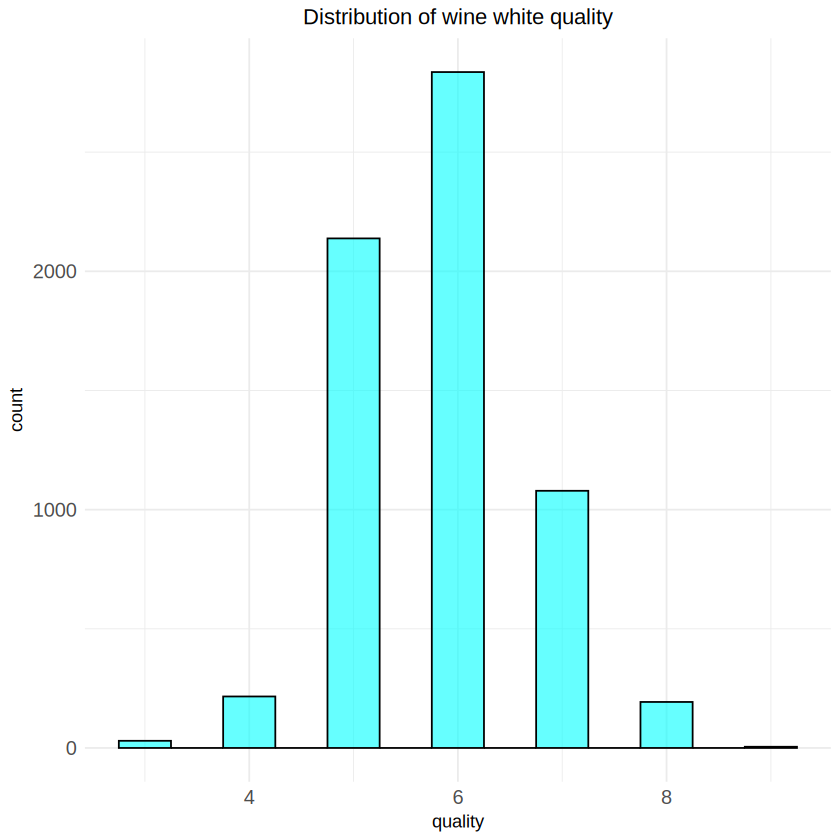

In [14]:
ggplot(wine_quality, aes(x = quality)) +
  geom_histogram(binwidth = 0.5, fill = "cyan", color = "black", alpha = 0.6) +
  theme_minimal() +
  ggtitle("Distribution of wine white quality") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Nhận xét:
- Chất lượng rượu có phân phối đối xứng 
- Hầu hết chất lượng rượu đỏ nằm ở mức 5, 6
- Không có rượu đỏ nào đạt điểm tuyệt đối
- Chất lượng rượu đỏ tệ nhất có điểm số là 3

### Khảo sát tính chua (acidity) trong rượu

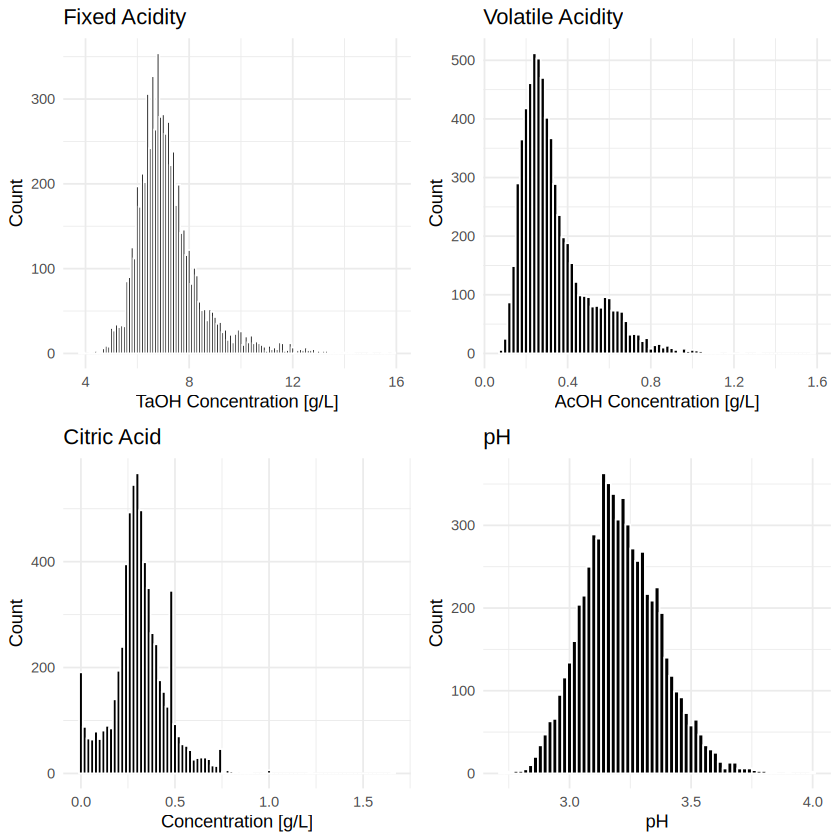

In [15]:
p1 <- ggplot(wine_quality, aes(x = fixed.acidity)) +
  geom_histogram(binwidth = 0.1, fill = "black", color = "white") +
  labs(title = "Fixed Acidity", x = "TaOH Concentration [g/L]", y = "Count") +
  theme_minimal()

p2 <- ggplot(wine_quality, aes(x = volatile.acidity)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "Volatile Acidity", x = "AcOH Concentration [g/L]", y = "Count") +
  theme_minimal()

p3 <- ggplot(wine_quality, aes(x = citric.acid)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "Citric Acid", x = "Concentration [g/L]", y = "Count") +
  theme_minimal()

p4 <- ggplot(wine_quality, aes(x = pH)) +
  geom_histogram(binwidth = 0.02, fill = "black", color = "white") +
  labs(title = "pH", x = "pH", y = "Count") +
  theme_minimal()

# Arrange the plots in a grid
grid.arrange(p1, p2, p3, p4, nrow = 2)

Warning message:
“The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
ℹ Please use the `fun` argument instead.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


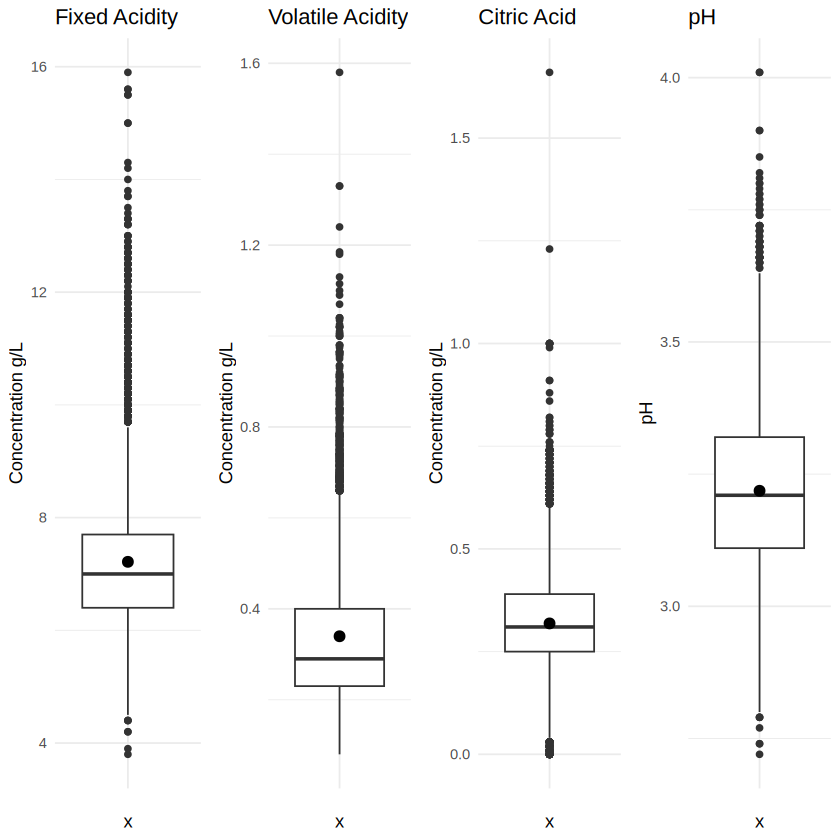

In [16]:
p1 <- ggplot(wine_quality, aes(x = "", y = fixed.acidity)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Fixed Acidity", y = "Concentration g/L") +
  theme_minimal()

p2 <- ggplot(wine_quality, aes(x = "", y = volatile.acidity)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Volatile Acidity", y = "Concentration g/L") +
  theme_minimal()

p3 <- ggplot(wine_quality, aes(x = "", y = citric.acid)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "Citric Acid", y = "Concentration g/L") +
  theme_minimal()

p4 <- ggplot(wine_quality, aes(x = "", y = pH)) +
  geom_boxplot() +
  stat_summary(fun.y="mean") +
  labs(title = "pH", y = "pH") +
  theme_minimal()

# Arrange the plots in a single row
grid.arrange(p1, p2, p3, p4, ncol = 4)

### Khảo sát hàm lượng lưu huỳnh trong rượu

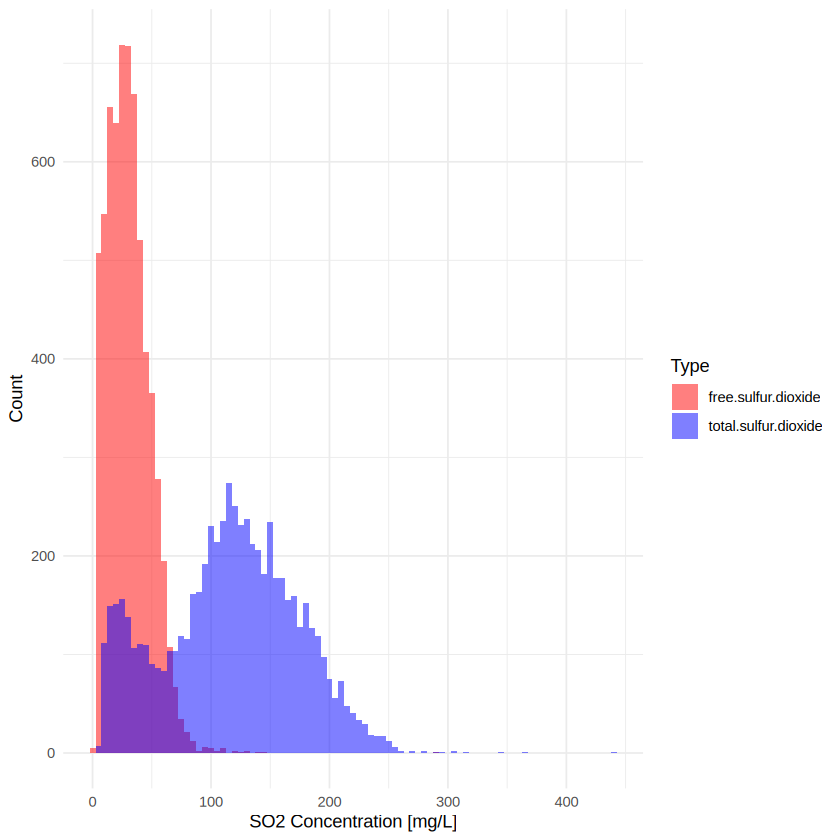

In [17]:
wine_data_long <- data.frame(
  value = c(wine_quality$free.sulfur.dioxide, wine_quality$total.sulfur.dioxide),
  type = rep(c("free.sulfur.dioxide", "total.sulfur.dioxide"), each = nrow(wine_quality))
)


ggplot(wine_data_long, aes(x = value, fill = type)) +
  geom_histogram(aes(y = after_stat(count)), binwidth = 5, position = "identity", alpha = 0.5) +
  labs(x = "SO2 Concentration [mg/L]", y = "Count", fill = "Type") +
  scale_fill_manual(values = c("red", "blue")) +
  theme_minimal() +
  theme(legend.position = "right")

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


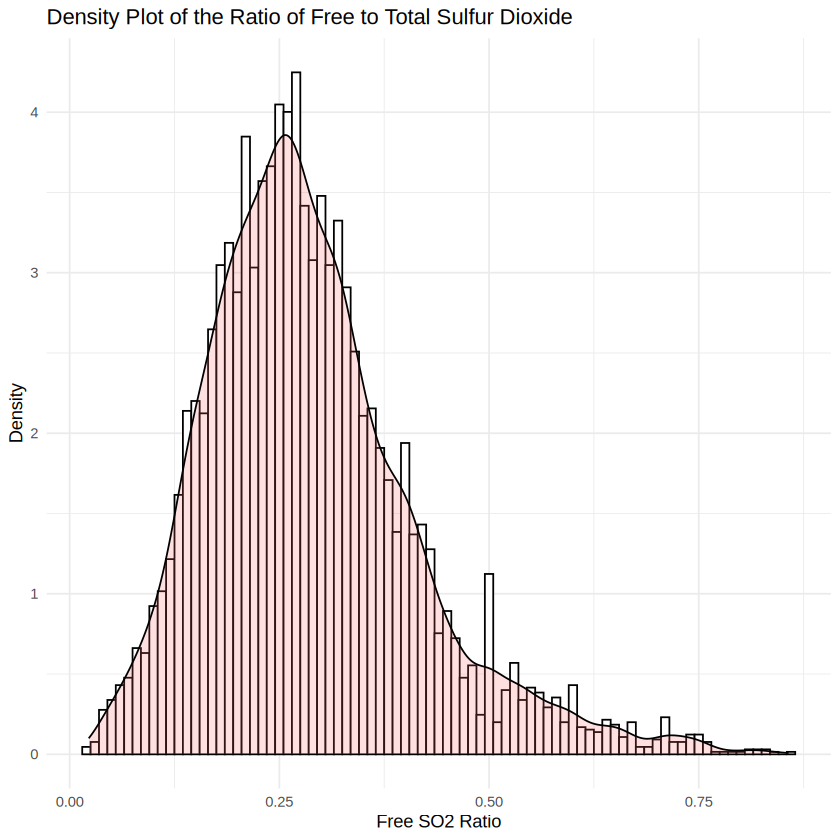

In [18]:
wine_combined <- wine_quality %>%
  mutate(ratio_sulfur_dioxide = free.sulfur.dioxide / total.sulfur.dioxide)

ggplot(wine_combined, aes(x = ratio_sulfur_dioxide)) +
  geom_histogram(aes(y = ..density..), binwidth = 0.01, fill = "white", color = "black") +
  geom_density(alpha = 0.2, fill = "#FF6666") +
  labs(title = "Density Plot of the Ratio of Free to Total Sulfur Dioxide",
       x = "Free SO2 Ratio",
       y = "Density") +
  theme_minimal()

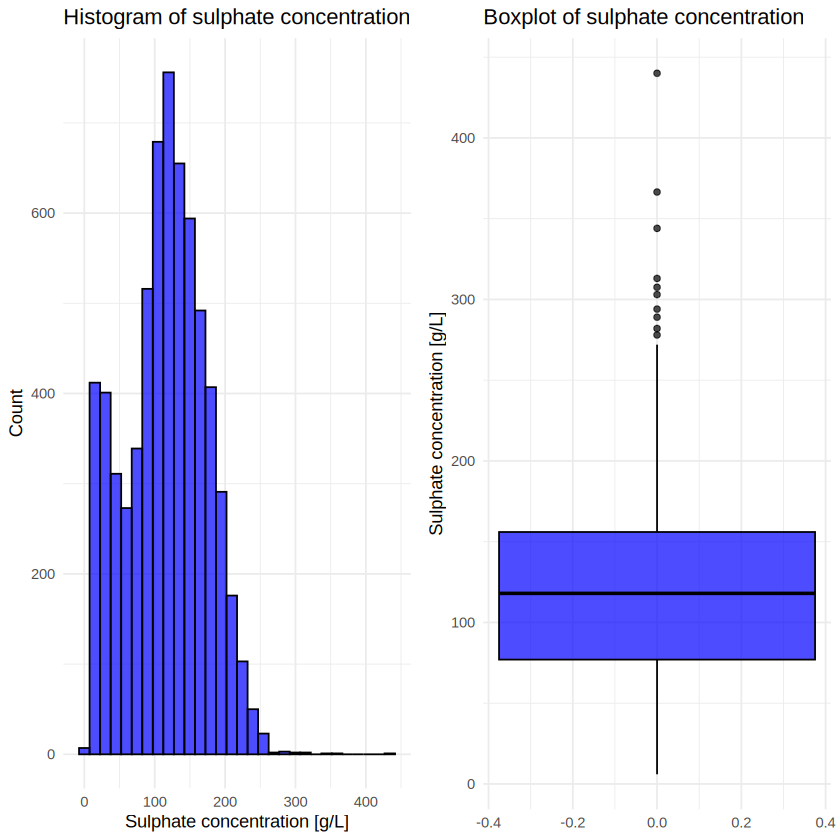

In [19]:
hist_plot <- ggplot(wine_quality, aes(x = total.sulfur.dioxide)) +
  geom_histogram(fill = "blue", color = "black", alpha = 0.7, bins = 30) +
  labs(title = "Histogram of sulphate concentration", x = "Sulphate concentration [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality, aes(y = total.sulfur.dioxide)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of sulphate concentration", y = "Sulphate concentration [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát lượng đường còn lại sau khi lên men trong rượu

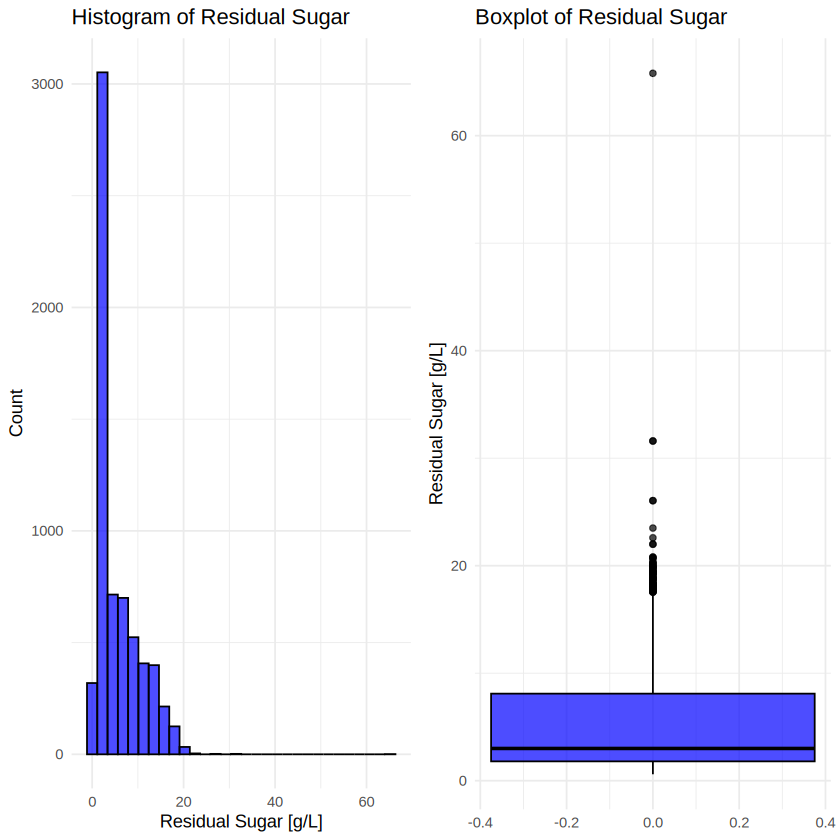

In [20]:
hist_plot <- ggplot(wine_quality, aes(x = residual.sugar)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of Residual Sugar", x = "Residual Sugar [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality, aes(y = residual.sugar)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of Residual Sugar", y = "Residual Sugar [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát phần trăm cồn trong rượu

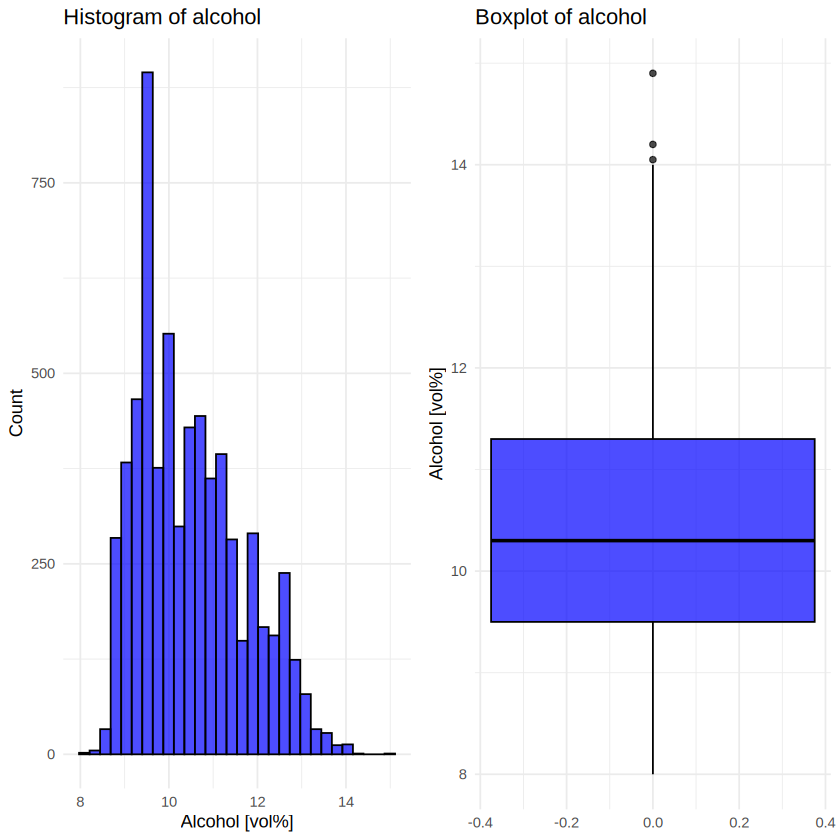

In [21]:
hist_plot <- ggplot(wine_quality, aes(x = alcohol)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of alcohol", x = "Alcohol [vol%]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality, aes(y = alcohol)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of alcohol", y = "Alcohol [vol%]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát mật độ trong rượu trắng

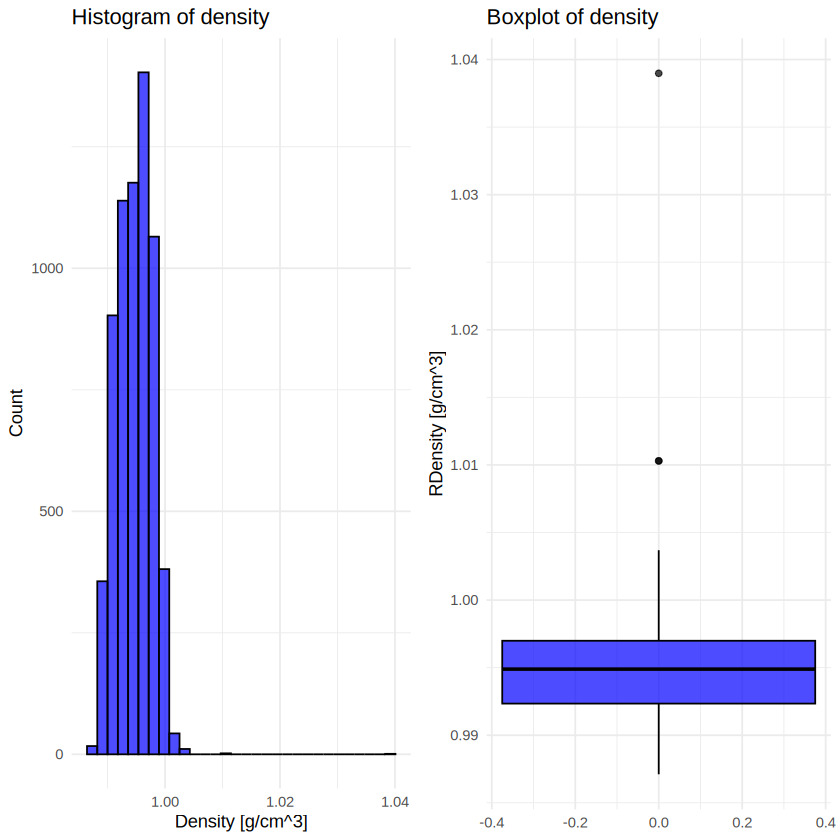

In [22]:
hist_plot <- ggplot(wine_quality, aes(x = density)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of density", x = "Density [g/cm^3]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality, aes(y = density)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of density", y = "RDensity [g/cm^3]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

### Khảo sát lượng muối trong rượu

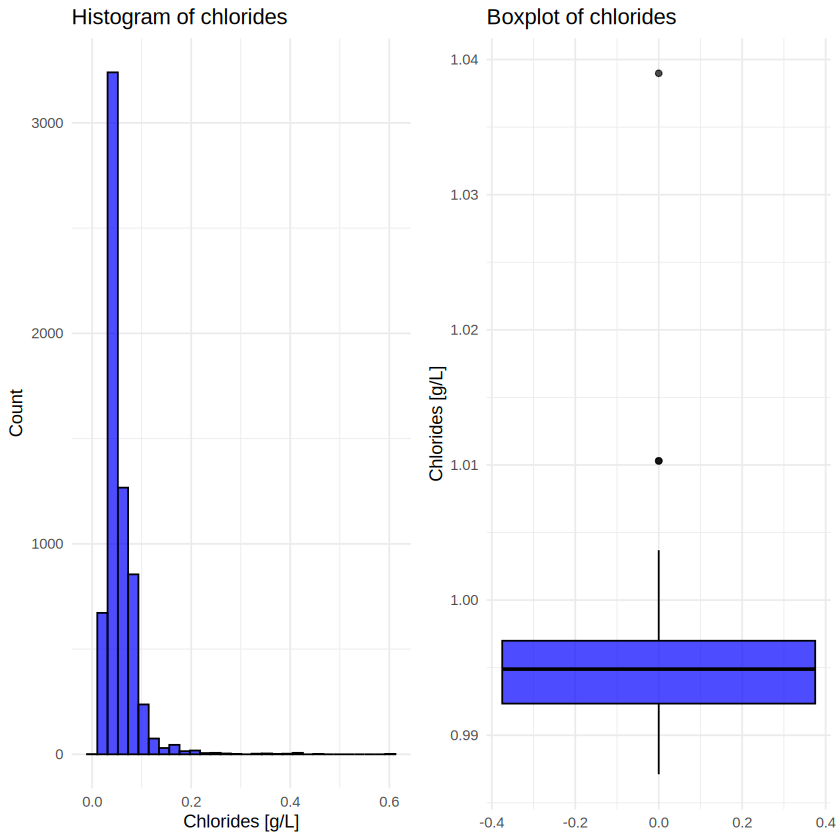

In [23]:
hist_plot <- ggplot(wine_quality, aes(x = chlorides)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogram of chlorides", x = "Chlorides [g/L]", y = "Count") +
  theme_minimal()

box_plot <- ggplot(wine_quality, aes(y = density)) +
  geom_boxplot(fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Boxplot of chlorides", y = "Chlorides [g/L]") +
  theme_minimal()

grid.arrange(hist_plot, box_plot, ncol = 2)

## Phân tích đa biến

### Phân tích ma trận tương quan

corrplot 0.92 loaded


Attaching package: ‘corrplot’


The following object is masked from ‘package:pls’:

    corrplot




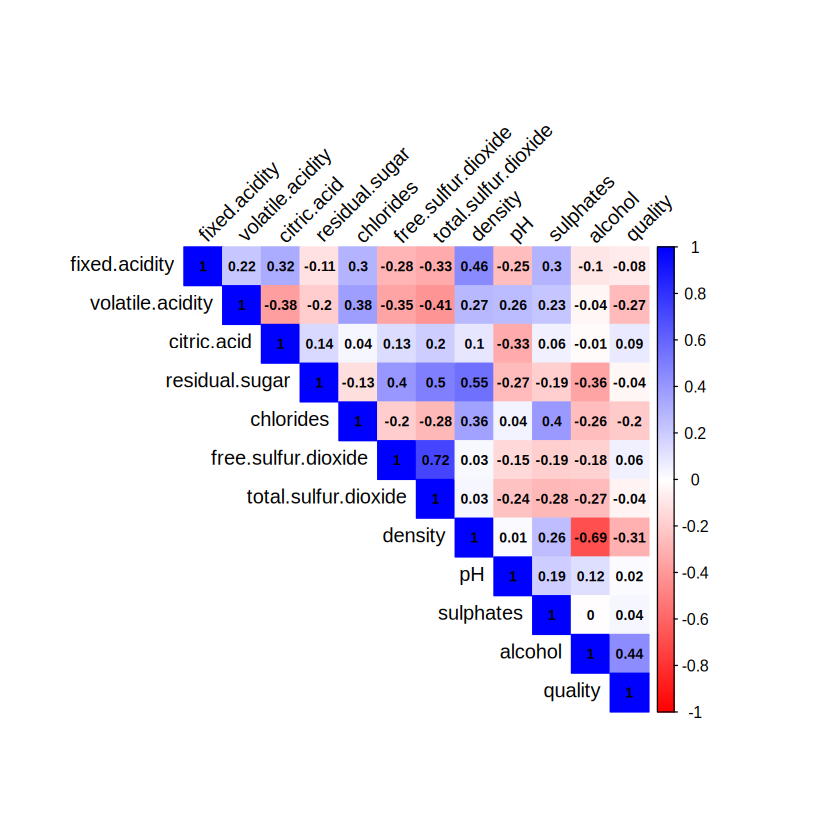

In [24]:
library(corrplot)

cor_matrix <- cor(wine_quality[-c(13)])

corrplot(cor_matrix, method = "color", type = "upper", 
         tl.col = "black", tl.srt = 45, addCoef.col = "black", number.cex = 0.7,
         col = colorRampPalette(c("red", "white", "blue"))(200))

In [25]:
threshold <- 0.3
positive_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if((cor_matrix[i, j]) > threshold) {
      positive_cor_pairs <- rbind(positive_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(positive_cor_pairs)

                  Var1                 Var2     value
1        fixed.acidity          citric.acid 0.3244357
2        fixed.acidity              density 0.4589100
3     volatile.acidity            chlorides 0.3771243
4       residual.sugar  free.sulfur.dioxide 0.4028706
5       residual.sugar total.sulfur.dioxide 0.4954816
6       residual.sugar              density 0.5525170
7            chlorides              density 0.3626147
8            chlorides            sulphates 0.3955933
9  free.sulfur.dioxide total.sulfur.dioxide 0.7209341
10             alcohol              quality 0.4443185


Chọn ngưỡng là 0.3, ta thấy:
- Nồng độ cồn (alcohol) có ảnh hưởng (thuận) đến chất lượng rượu (chỉ số tương quan 0.436)
- Các biến `residual.sugar` và `density` có tương quan thuận cao 0.83

In [26]:
threshold <- -0.3
negative_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if((cor_matrix[i, j]) < threshold) {
      negative_cor_pairs <- rbind(negative_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(negative_cor_pairs)

              Var1                 Var2      value
1    fixed.acidity total.sulfur.dioxide -0.3290539
2 volatile.acidity          citric.acid -0.3779813
3 volatile.acidity  free.sulfur.dioxide -0.3525573
4 volatile.acidity total.sulfur.dioxide -0.4144762
5      citric.acid                   pH -0.3298082
6   residual.sugar              alcohol -0.3594148
7          density              alcohol -0.6867454
8          density              quality -0.3058579


Chọn ngưỡng là 0.3, ta thấy:
- Mật độ trong rượu (`density`) có ảnh hưởng (nghịch) đến chất lượng của rượu (chỉ số tương quan -0.307)
- Các biến `alcohol` và `density` có tương quan nghịch cao -0.78

### Phân tích ảnh hưởng của các biến đối với chất lượng rượu

#### Khảo sát mối quan hệ giữa `Density` và `Quality`

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 492 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 492 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 5”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1”
Warning message:
“Removed 492 rows containing missing values or values outside the scale range
(`geom_point()`).”


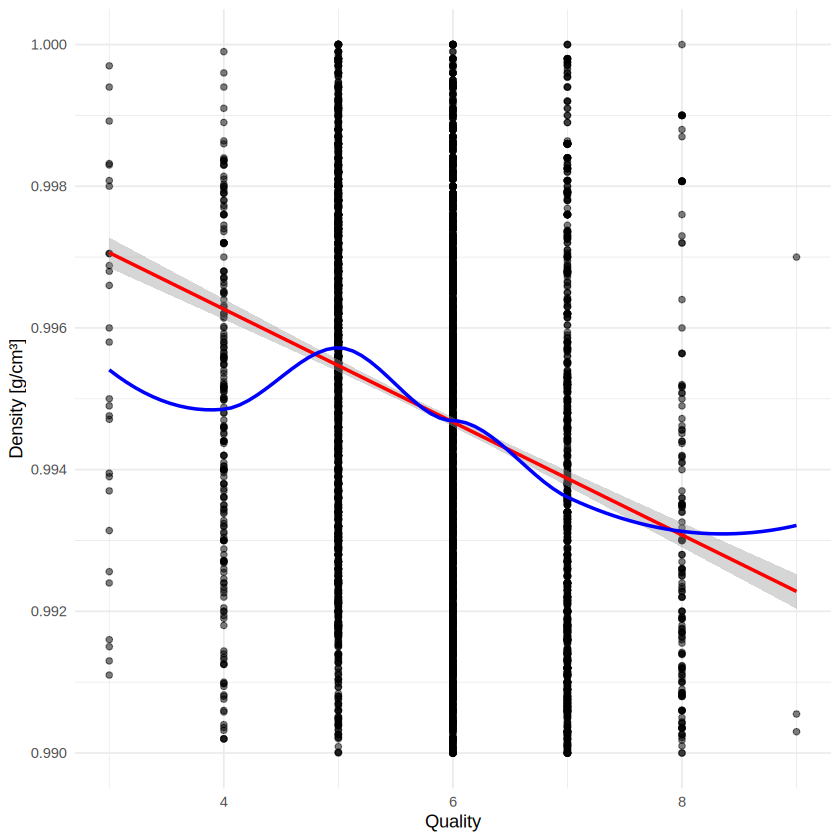

In [27]:
ggplot(wine_quality, aes(x = quality, y = density)) +
  geom_point(color = "black", alpha = 0.5) + 
  geom_smooth(method = "lm", color = "red", se = TRUE) +
  geom_smooth(method = "loess", color = "blue", se = FALSE) +
  scale_y_continuous(name = "Density [g/cm³]", limits = c(0.990, 1.000), breaks = seq(0.990, 1.000, 0.002)) +
  labs(x = "Quality", y = "Density [g/cm³]") +
  theme_minimal()

Warning message:
“Removed 155 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


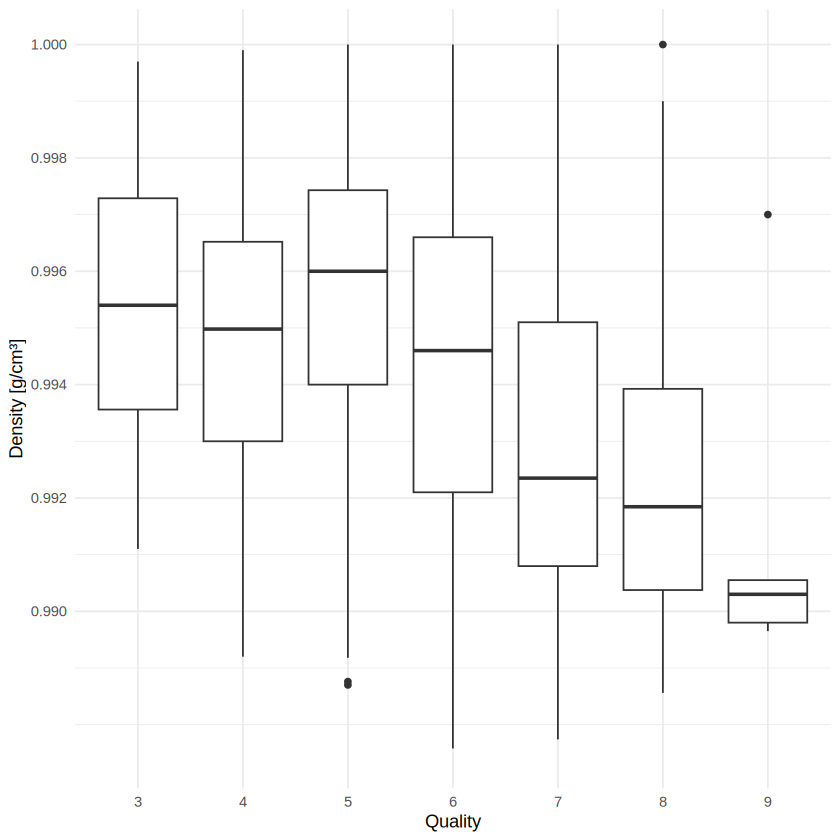

In [28]:
ggplot(wine_quality, aes(x = factor(quality), y = density)) +
  geom_boxplot() +
  labs(x = "Quality", y = "Density [g/cm³]") +
  scale_y_continuous(name = "Density [g/cm³]", limits = c(0.9875, 1.000), breaks = seq(0.990, 1.000, 0.002)) +
  theme_minimal()

#### Khảo sát mối quan hệ giữa Alcohol và Quality

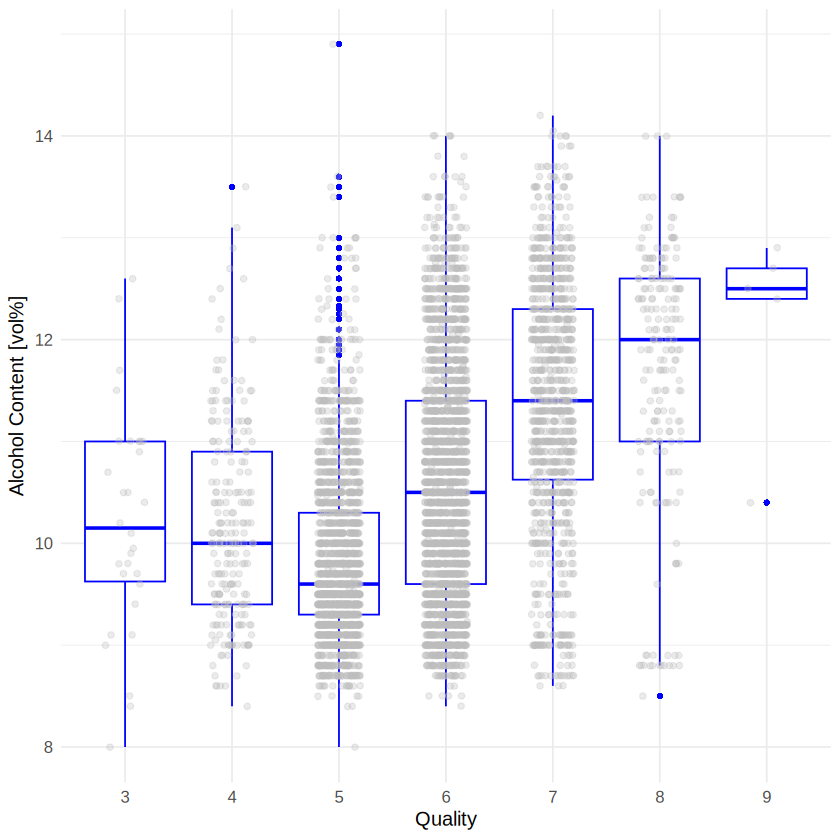

In [29]:
ggplot(wine_quality, aes(x = factor(quality), y = alcohol)) +
  geom_boxplot(color = "blue", outlier.color = "blue", outlier.shape = 16) +
  geom_jitter(width = 0.2, alpha = 0.3, color = "grey") +
  labs(x = "Quality", y = "Alcohol Content [vol%]") +
  theme_minimal() +
  theme(
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    axis.text.x = element_text(size = 10),
    axis.text.y = element_text(size = 10)
  )

#### Khảo sát mối quan hệ giữa Chlorides và Quality

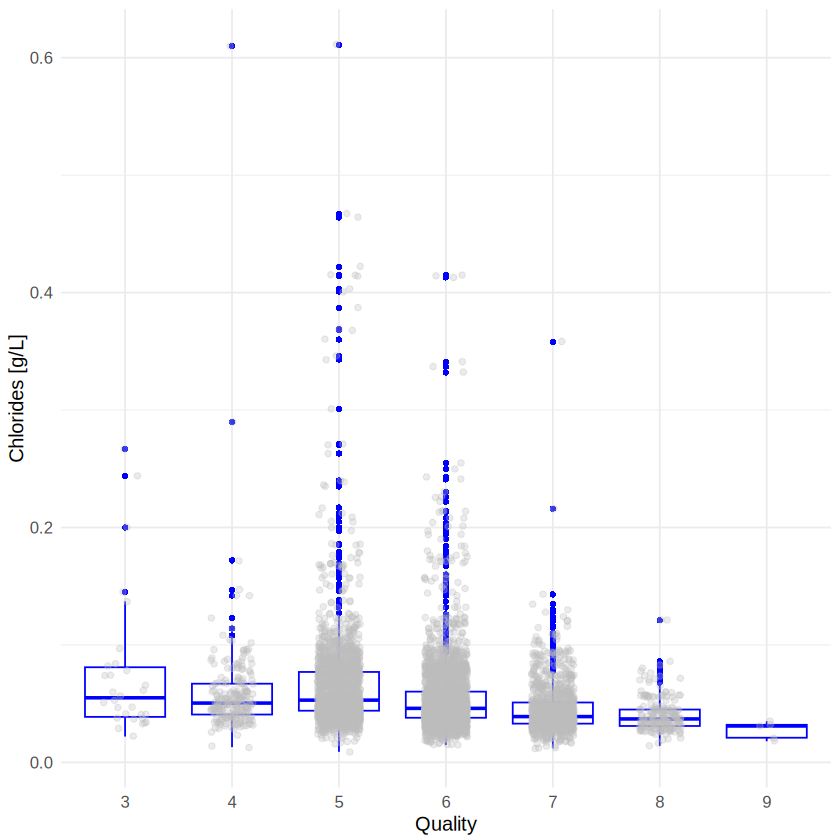

In [30]:
ggplot(wine_quality, aes(x = factor(quality), y = chlorides)) +
  geom_boxplot(color = "blue", outlier.color = "blue", outlier.shape = 16) +
  geom_jitter(width = 0.2, alpha = 0.3, color = "grey") +
  labs(x = "Quality", y = "Chlorides [g/L]") +
  theme_minimal() +
  theme(
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    axis.text.x = element_text(size = 10),
    axis.text.y = element_text(size = 10)
  )

#### Khảo sát mối quan hệ giữa Volatile Acidity và Quality

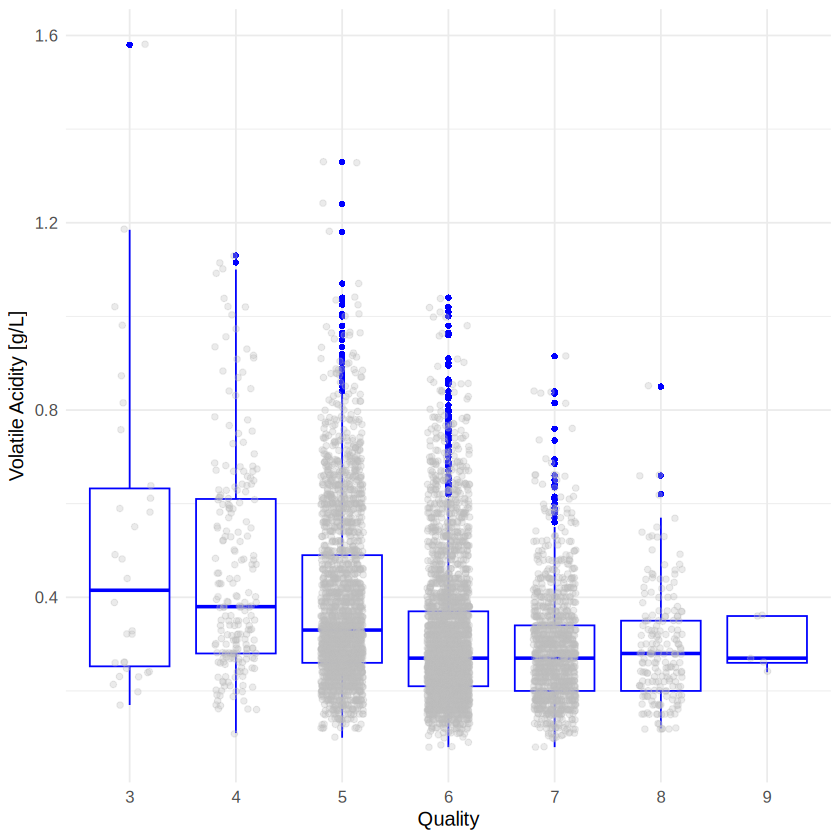

In [31]:
ggplot(wine_quality, aes(x = factor(quality), y = volatile.acidity)) +
  geom_boxplot(color = "blue", outlier.color = "blue", outlier.shape = 16) +
  geom_jitter(width = 0.2, alpha = 0.3, color = "grey") +
  labs(x = "Quality", y = "Volatile Acidity [g/L]") +
  theme_minimal() +
  theme(
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    axis.text.x = element_text(size = 10),
    axis.text.y = element_text(size = 10)
  )

#### Khảo sát mối quan hệ giữa tổng lượng SO2 và lượng đường còn lại sau khi lên men

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


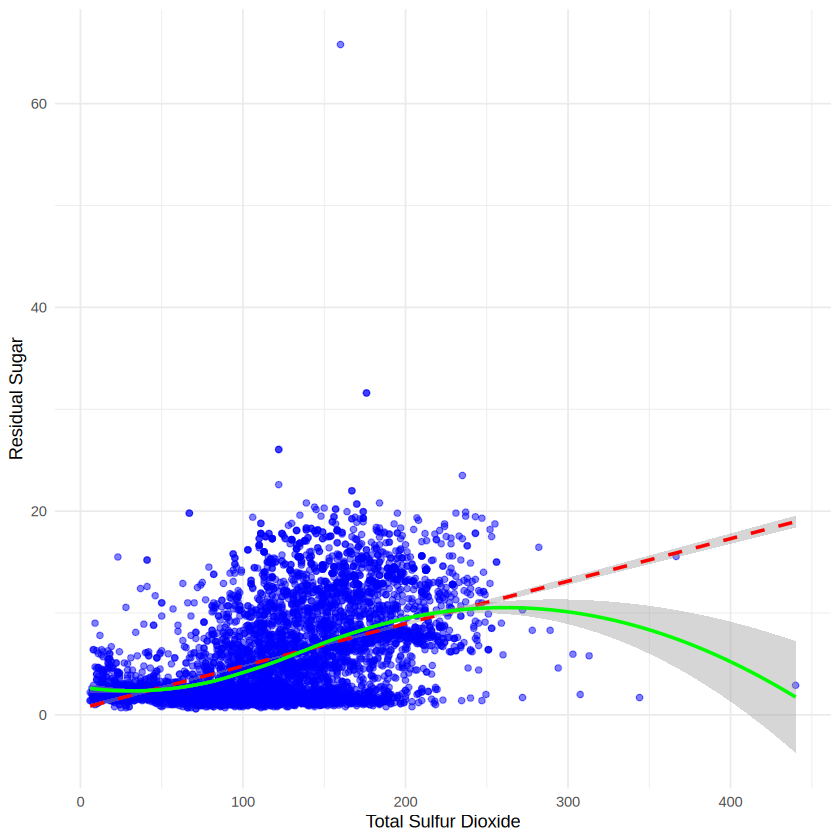

In [32]:
ggplot(wine_quality, aes(x = total.sulfur.dioxide, y = residual.sugar)) +
  geom_point(color = "blue", alpha = 0.5) + 
  geom_smooth(method = "lm", color = "red", se = TRUE, linetype = "dashed") +
  geom_smooth(method = "loess", color = "green", se = TRUE) +
  labs(x = "Total Sulfur Dioxide", y = "Residual Sugar") +
  theme_minimal()

#### Khảo sát tác động của nồng độ cồn và lượng đường đến mật độ rượu

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


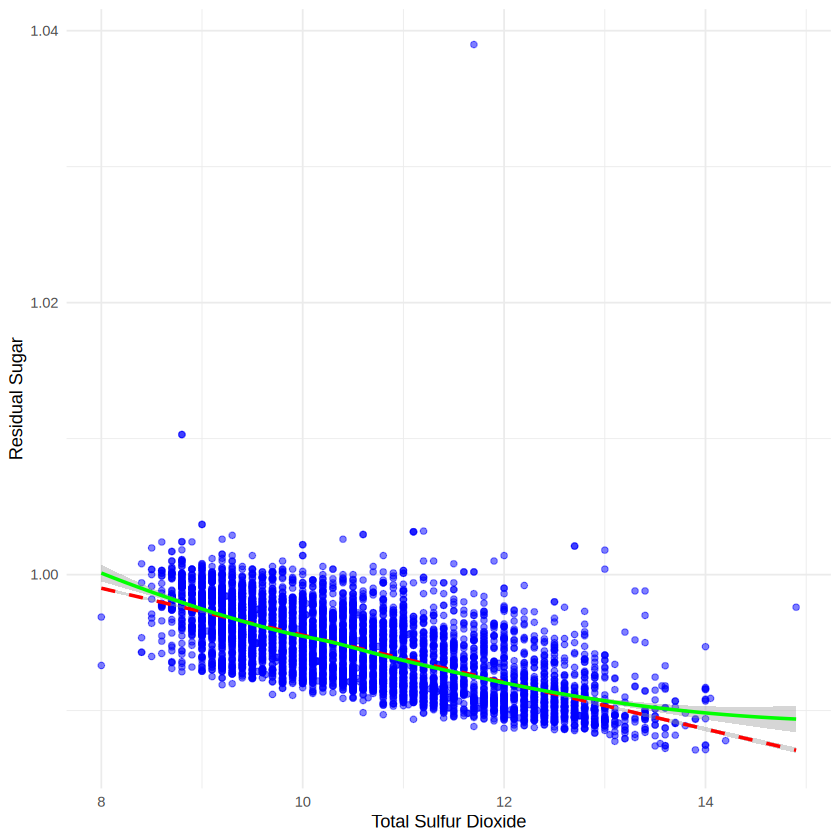

In [33]:
ggplot(wine_quality, aes(x = alcohol, y = density)) +
  geom_point(color = "blue", alpha = 0.5) + 
  geom_smooth(method = "lm", color = "red", se = TRUE, linetype = "dashed") +
  geom_smooth(method = "loess", color = "green", se = TRUE) +
  labs(x = "Total Sulfur Dioxide", y = "Residual Sugar") +
  theme_minimal()

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


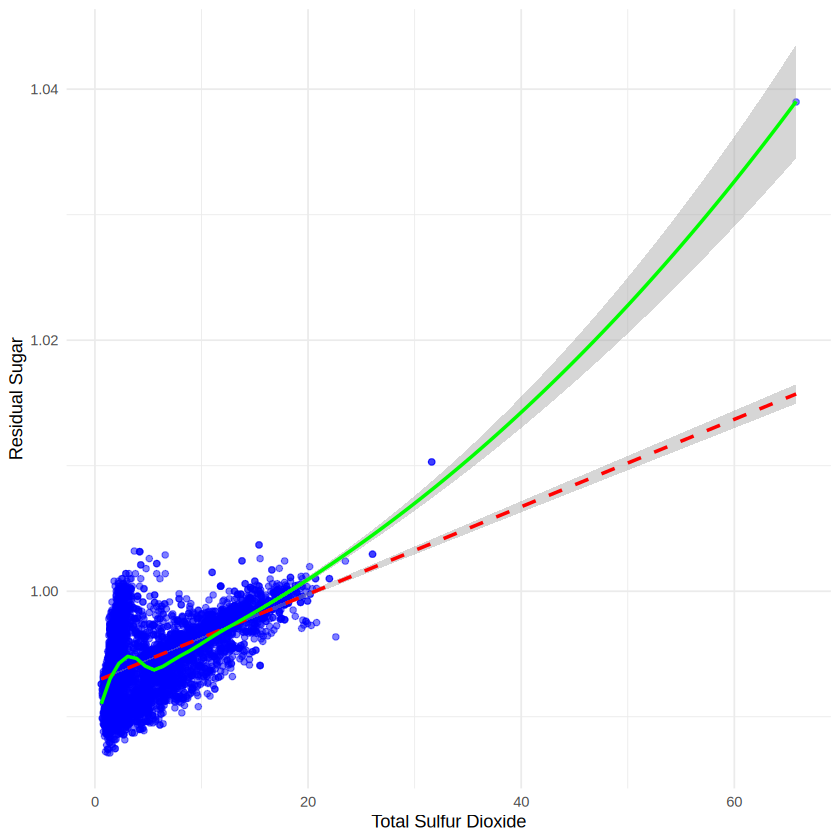

In [34]:
ggplot(wine_quality, aes(x = residual.sugar, y = density)) +
  geom_point(color = "blue", alpha = 0.5) + 
  geom_smooth(method = "lm", color = "red", se = TRUE, linetype = "dashed") +
  geom_smooth(method = "loess", color = "green", se = TRUE) +
  labs(x = "Total Sulfur Dioxide", y = "Residual Sugar") +
  theme_minimal()

### Phân tích dựa trên màu sắc của rượu

#### Phân tích mối quan hệ giữa màu sắc và mật độ rượu

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 22 rows containing non-finite outside the scale range
(`stat_density()`).”


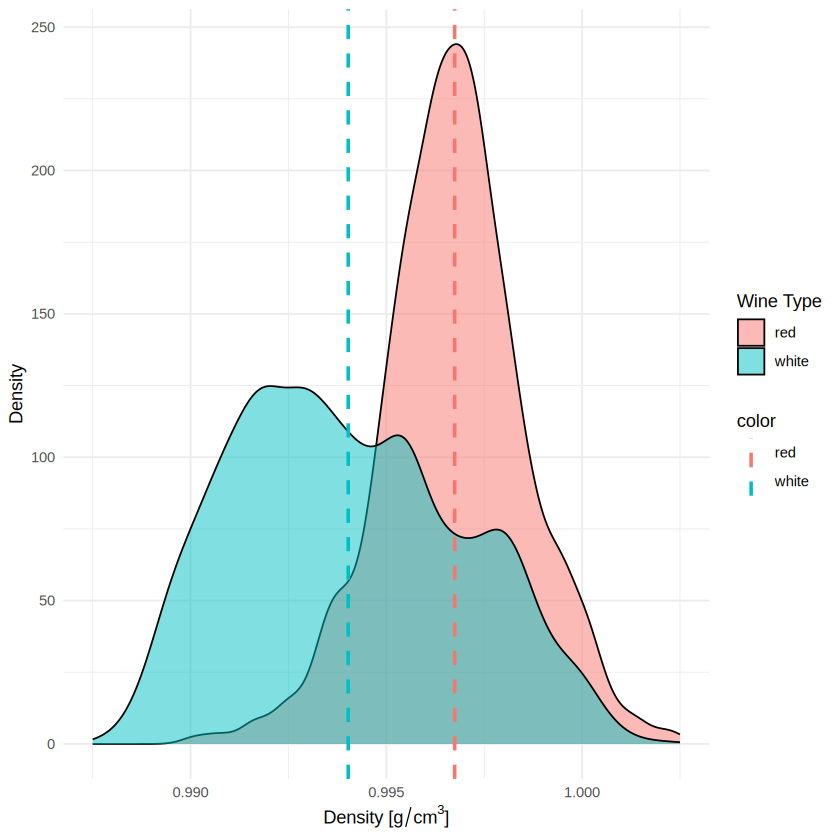

In [35]:
ggplot(wine_quality, aes(x = density, fill = color)) +
  geom_density(alpha = 0.5) +
  geom_vline(data = wine_quality %>% group_by(color) %>% summarize(mean = mean(density)), 
             aes(xintercept = mean, color = color), linetype = "dashed", size = 1) +
  labs(x = expression(Density~"["*g/cm^3*"]"), y = 'Density', fill = 'Wine Type') +
  scale_x_continuous(limits = c(0.9875, 1.0025)) +
  theme_minimal()

#### Phân tích mối quan hệ giữa màu sắc và lượng đường còn lại sau khi lên men

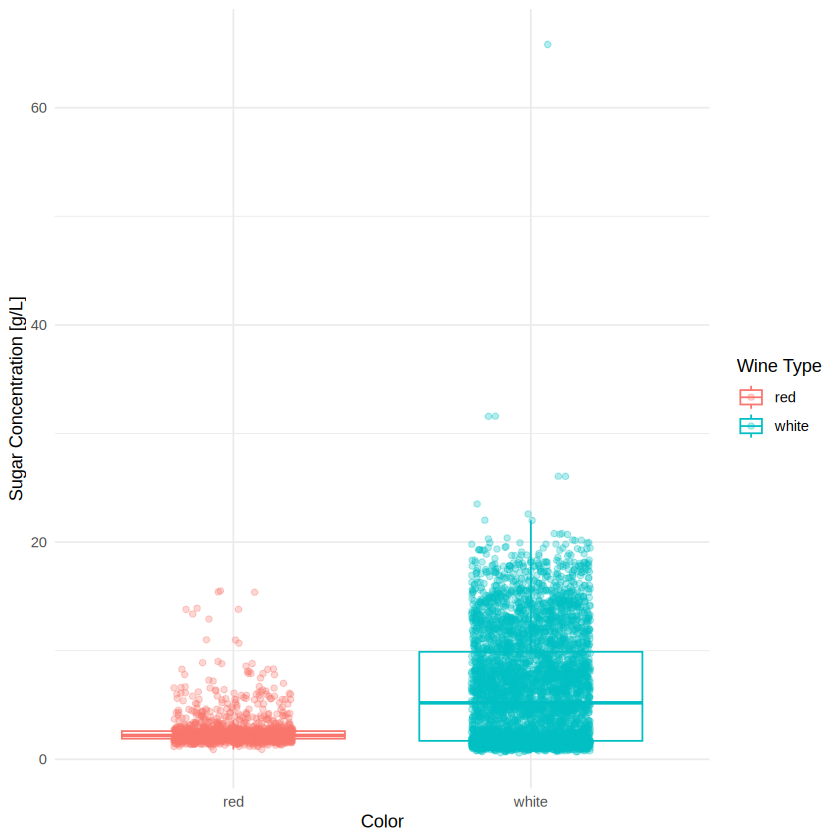

In [36]:
ggplot(wine_quality, aes(x = color, y = `residual.sugar`, color = color)) +
  geom_boxplot(outlier.shape = NA) +
  geom_jitter(alpha = 0.3, width = 0.2) +
  labs(x = 'Color', y = 'Sugar Concentration [g/L]', color = 'Wine Type') +
  theme_minimal()

#### Phân tích mối quan hệ giữa màu sắc và tổng lượng lưu huỳnh trong rượu

Warning message:
“Removed 393 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


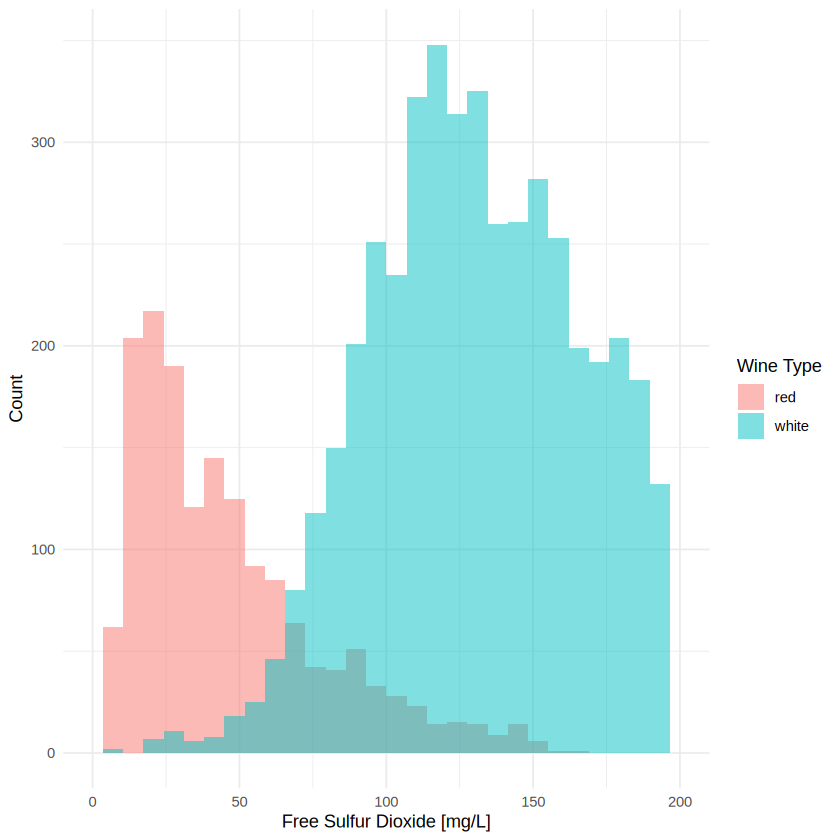

In [37]:
ggplot(wine_quality, aes(x = `total.sulfur.dioxide`, fill = color)) +
  geom_histogram(position = 'identity', alpha = 0.5, bins = 30) +
  labs(x = 'Free Sulfur Dioxide [mg/L]', y = 'Count', fill = 'Wine Type') +
  scale_x_continuous(limits = c(0, 200)) +
  theme_minimal()

#### Phân tích mối quan hệ giữa màu sắc và lượng cố định lưu huỳnh trong rượu

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


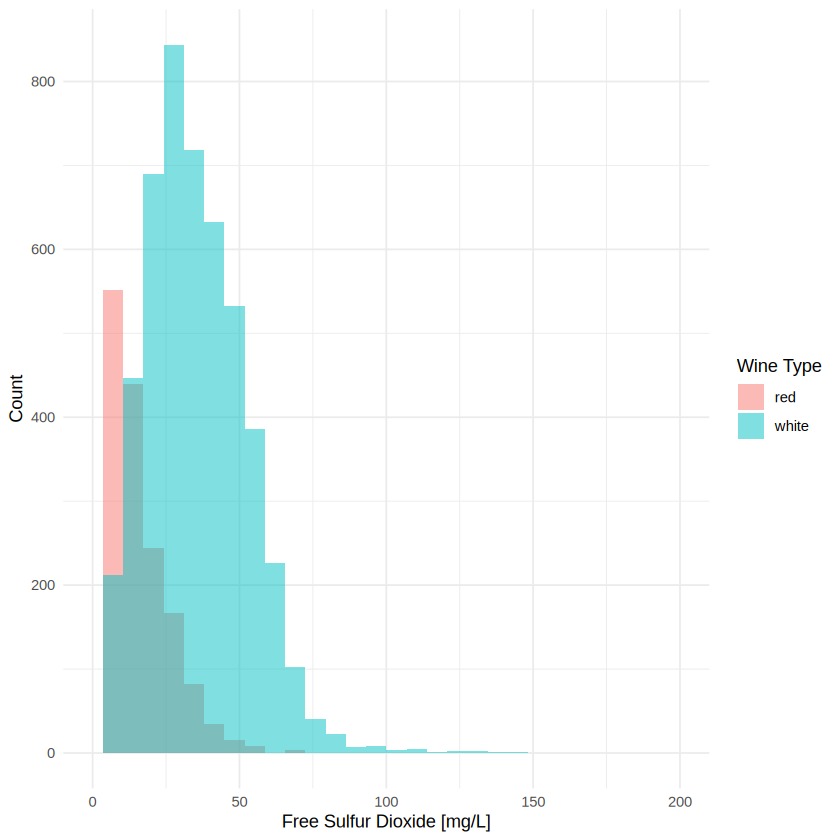

In [38]:
ggplot(wine_quality, aes(x = `free.sulfur.dioxide`, fill = color)) +
  geom_histogram(position = 'identity', alpha = 0.5, bins = 30) +
  labs(x = 'Free Sulfur Dioxide [mg/L]', y = 'Count', fill = 'Wine Type') +
  scale_x_continuous(limits = c(0, 200)) +
  theme_minimal()

#### Phân tích mối quan hệ giữa màu sắc và tính chua của rượu

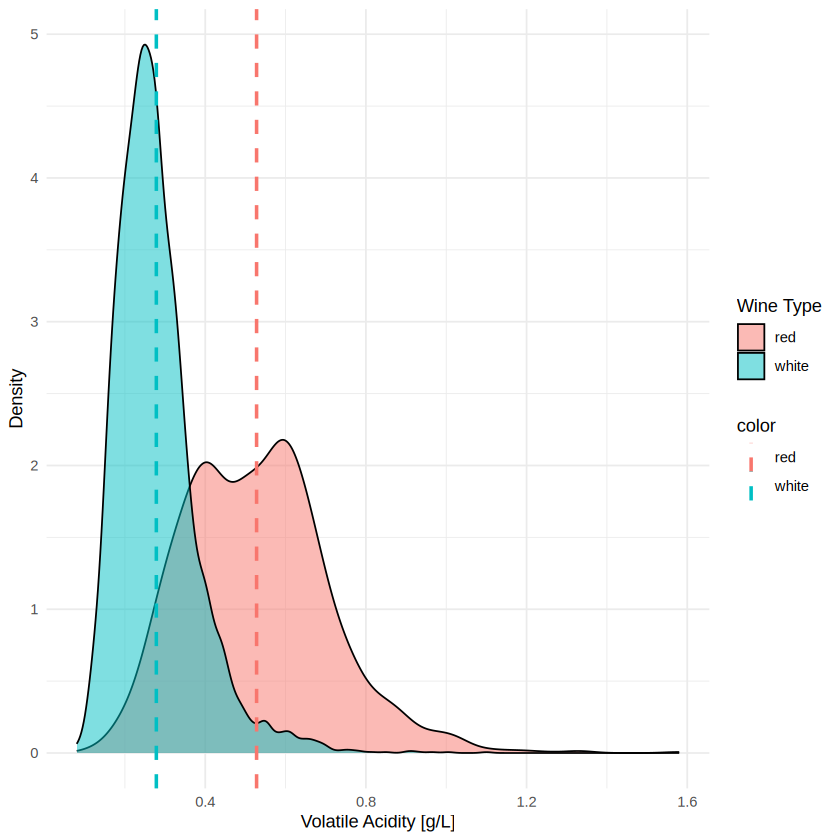

In [39]:
ggplot(wine_quality, aes(x = volatile.acidity, fill = color)) +
  geom_density(alpha = 0.5) +
  geom_vline(data = wine_quality %>% group_by(color) %>% summarize(mean = mean(`volatile.acidity`)), 
             aes(xintercept = mean, color = color), linetype = "dashed", size = 1) +
  labs(x = 'Volatile Acidity [g/L]', y = 'Density', fill = 'Wine Type') +
  theme_minimal()

### Phân tích tương quan giữa các biến dựa trên màu sắc

#### Khảo sát tương quan giữa mật độ và chất lượng rượu dựa trên màu sắc

Warning message:
“Removed 3 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


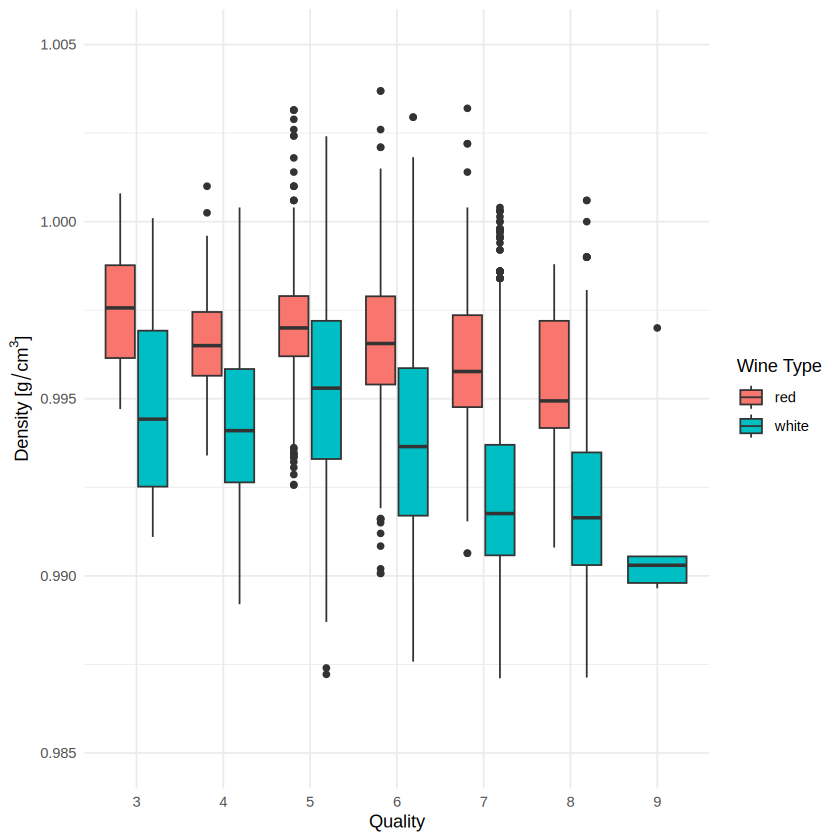

In [41]:
ggplot(wine_quality, aes(x = as.factor(quality), y = density, fill = color)) +
  geom_boxplot() +
  labs(x = 'Quality', y = expression(Density~"["*g/cm^3*"]"), fill = 'Wine Type') +
  scale_y_continuous(limits = c(0.985, 1.005)) +
  theme_minimal()

#### Khảo sát tương quan giữa nồng độ cồn và chất lượng rượu dựa trên màu sắc 

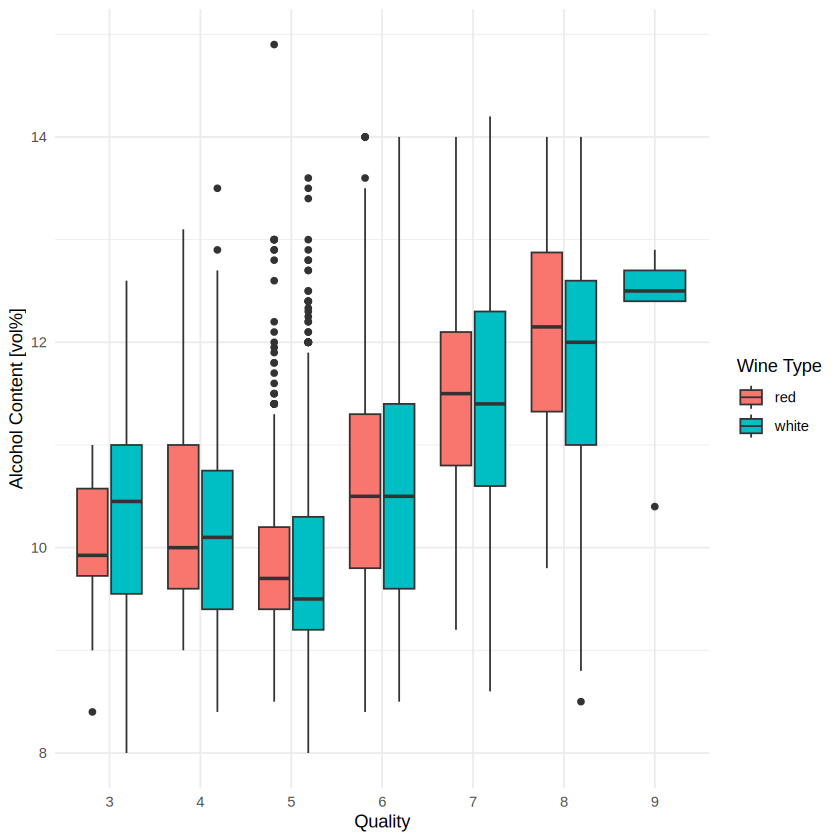

In [44]:
ggplot(wine_quality, aes(x = as.factor(quality), y = alcohol, fill = color)) +
  geom_boxplot() +
  labs(x = 'Quality', y = "Alcohol Content [vol%]", fill = 'Wine Type') +
#   scale_y_continuous(limits = c(0.985, 1.005)) +
  theme_minimal()

#### Khảo sát tương quan giữa lượng muối và chất lượng rượu dựa trên màu sắc

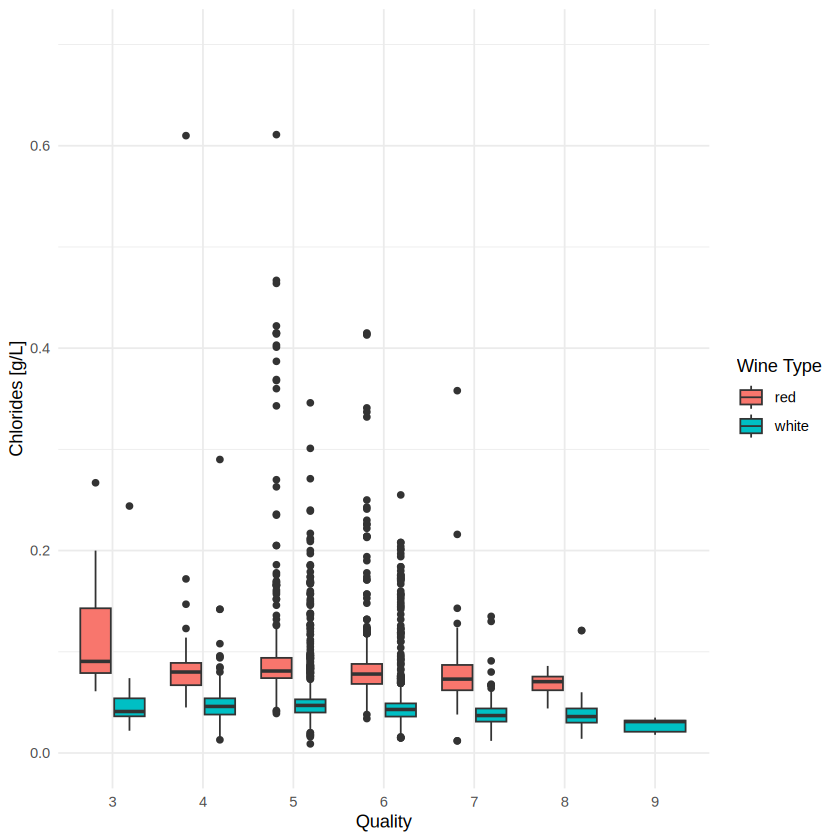

In [51]:
ggplot(wine_quality, aes(x = as.factor(quality), y = chlorides, fill = color)) +
  geom_boxplot() +
  labs(x = 'Quality', y = "Chlorides [g/L]", fill = 'Wine Type') +
  scale_y_continuous(limits = c(0., 0.7)) +
  theme_minimal()

#### Khảo sát tương quan giữa độ chua và chất lượng rượu dựa trên màu sắc

Warning message:
“Removed 241 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


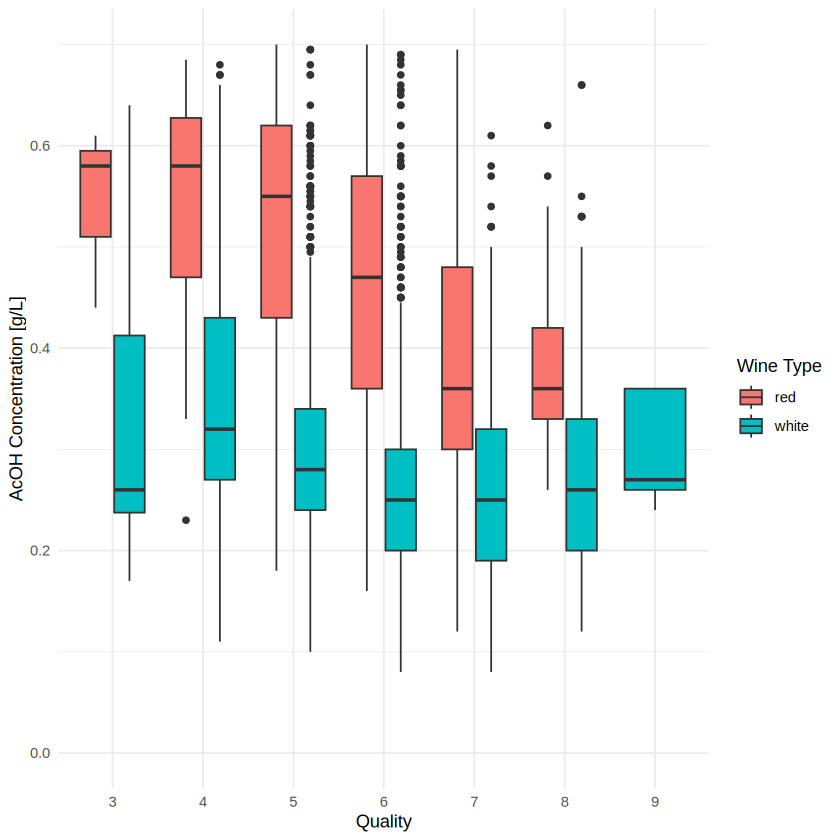

In [52]:
ggplot(wine_quality, aes(x = as.factor(quality), y = volatile.acidity, fill = color)) +
  geom_boxplot() +
  labs(x = 'Quality', y = "AcOH Concentration [g/L]", fill = 'Wine Type') +
  scale_y_continuous(limits = c(0., 0.7)) +
  theme_minimal()

## Khảo sát đa cộng tuyến

In [30]:
model <- lm(quality ~ ., data = wine_quality)
vif_values <- vif(model)
print(vif_values)

       fixed.acidity     volatile.acidity          citric.acid 
            5.048348             2.168159             1.622151 
      residual.sugar            chlorides  free.sulfur.dioxide 
            9.634653             1.659342             2.235693 
total.sulfur.dioxide              density                   pH 
            4.045899            22.337223             2.563776 
           sulphates              alcohol                color 
            1.555807             5.616857             7.224467 


In [31]:
threshold <- 3
while (any(vif_values > threshold)) {
  highest_vif <- which.max(vif_values)
  variable_to_remove <- names(vif_values)[highest_vif]
  formula <- as.formula(paste("quality ~ . -", variable_to_remove))
  model <- update(model, formula)
  vif_values <- vif(model)
}

In [32]:
print(vif_values)
summary(model)

       fixed.acidity     volatile.acidity          citric.acid 
            1.783515             1.703665             1.608022 
      residual.sugar            chlorides  free.sulfur.dioxide 
            1.511206             1.564130             2.135374 
total.sulfur.dioxide                   pH            sulphates 
            2.843819             1.415649             1.347969 
             alcohol 
            1.410019 



Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    pH + sulphates + alcohol, data = wine_quality)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8056 -0.4637 -0.0367  0.4685  3.0529 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.9132915  0.2755174   6.944 4.17e-12 ***
fixed.acidity         0.0114495  0.0094124   1.216   0.2239    
volatile.acidity     -1.4523016  0.0724401 -20.048  < 2e-16 ***
citric.acid          -0.1136536  0.0797334  -1.425   0.1541    
residual.sugar        0.0227933  0.0023608   9.655  < 2e-16 ***
chlorides            -0.7908671  0.3261855  -2.425   0.0154 *  
free.sulfur.dioxide   0.0059939  0.0007523   7.968 1.89e-15 ***
total.sulfur.dioxide -0.0022574  0.0002726  -8.281  < 2e-16 ***
pH                    0.1672385  0.0676144   2.473   0.0134 *  
sulphates             0.6460948  0.071290

In [33]:
clean_df <- wine_quality[,names((vif_values))]
clean_df$quality <- wine_quality$quality
head(clean_df)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.4,0.70,0.00,1.9,0.076,11,34,3.51,0.56,9.4,5
2,7.8,0.88,0.00,2.6,0.098,25,67,3.20,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15,54,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17,60,3.16,0.58,9.8,6
5,7.4,0.70,0.00,1.9,0.076,11,34,3.51,0.56,9.4,5
6,7.4,0.66,0.00,1.8,0.075,13,40,3.51,0.56,9.4,5


In [34]:
wine_quality <- clean_df

## Khảo sát ngoại lai

In [35]:
# Khảo sát ngoại lai theo biến diff
diff_data <- wine_quality
outliers_index <- list()
extreme_outliers_index <- list()

for (i in 1:ncol(diff_data)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(diff_data[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(diff_data[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = diff_data[diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(diff_data)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = diff_data[, i] < (Q1 - 3 * IQR) | diff_data[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(diff_data)) {
  print(paste("Biến:", names(diff_data)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(diff_data)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(diff_data)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(diff_data)){
    outliers = c(outliers, outliers_index[[names(diff_data)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(diff_data)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: fixed.acidity"
[1] "Số ngoại lai: 357"
[1] "Số cực ngoại lai: 86"
[1] "Biến: volatile.acidity"
[1] "Số ngoại lai: 377"
[1] "Số cực ngoại lai: 47"
[1] "Biến: citric.acid"
[1] "Số ngoại lai: 509"
[1] "Số cực ngoại lai: 15"
[1] "Biến: residual.sugar"
[1] "Số ngoại lai: 118"
[1] "Số cực ngoại lai: 3"
[1] "Biến: chlorides"
[1] "Số ngoại lai: 286"
[1] "Số cực ngoại lai: 133"
[1] "Biến: free.sulfur.dioxide"
[1] "Số ngoại lai: 62"
[1] "Số cực ngoại lai: 8"
[1] "Biến: total.sulfur.dioxide"
[1] "Số ngoại lai: 10"
[1] "Số cực ngoại lai: 1"
[1] "Biến: pH"
[1] "Số ngoại lai: 73"
[1] "Số cực ngoại lai: 2"
[1] "Biến: sulphates"
[1] "Số ngoại lai: 191"
[1] "Số cực ngoại lai: 35"
[1] "Biến: alcohol"
[1] "Số ngoại lai: 3"
[1] "Số cực ngoại lai: 0"
[1] "Biến: quality"
[1] "Số ngoại lai: 228"
[1] "Số cực ngoại lai: 0"
[1] "Tổng số ngoại lai: 1657"
[1] "Tổng số cực ngoại lai: 304"


In [36]:
cleaned_df <- wine_quality[-extreme_outliners, ]
dim(cleaned_df)
dim(wine_quality)

[1] 6193   11

[1] 6497   11

In [37]:
wine_quality <- cleaned_df

## Chuẩn hóa dữ liệu

In [38]:
wine_quality <- bc_transform(wine_quality)
head(wine_quality)

[1] "fixed.acidity"
[1] "Optimal lambda: -2"
[1] "volatile.acidity"
[1] "Optimal lambda: -2"
[1] "citric.acid"
[1] "Optimal lambda: -2"
[1] "residual.sugar"
[1] "Optimal lambda: -2"
[1] "chlorides"
[1] "Optimal lambda: -2"
[1] "free.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "total.sulfur.dioxide"
[1] "Optimal lambda: -2"
[1] "pH"
[1] "Optimal lambda: -2"
[1] "sulphates"
[1] "Optimal lambda: -2"
[1] "alcohol"
[1] "Optimal lambda: -2"
[1] "quality"
[1] "Optimal lambda: -2"


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4908692,-0.5204082,0.00000000,0.3614958,-86.06510,0.4958678,0.4995675,0.4594159,-1.0943878,0.4943413,0.4800000
2,0.4917817,-0.1456612,0.00000000,0.4260355,-51.56164,0.4992000,0.4998886,0.4511719,-0.5813149,0.4947938,0.4800000
3,0.4917817,-0.3656510,0.03772189,0.4054820,-58.57372,0.4977778,0.4998285,0.4529527,-0.6834320,0.4947938,0.4800000
4,0.4960140,-5.8775510,0.29454306,0.3614958,-88.38889,0.4982699,0.4998611,0.4499279,-0.9863258,0.4947938,0.4861111
5,0.4908692,-0.5204082,0.00000000,0.3614958,-86.06510,0.4958678,0.4995675,0.4594159,-1.0943878,0.4943413,0.4800000
6,0.4908692,-0.6478421,0.00000000,0.3456790,-88.38889,0.4970414,0.4996875,0.4594159,-1.0943878,0.4943413,0.4800000


## Phân chia tập dữ liệu

In [39]:
split_ratio <- 0.8
split_index <- floor(nrow(wine_quality) * split_ratio)

train = wine_quality[1:split_index,]
test = wine_quality[(split_index + 1):nrow(wine_quality),]

In [40]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 4954   11

In [41]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 1239   11

In [42]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	4954 obs. of  11 variables:
 $ fixed.acidity       : num  0.491 0.492 0.492 0.496 0.491 ...
 $ volatile.acidity    : num  -0.52 -0.146 -0.366 -5.878 -0.52 ...
 $ citric.acid         : num  0 0 0.0377 0.2945 0 ...
 $ residual.sugar      : num  0.361 0.426 0.405 0.361 0.361 ...
 $ chlorides           : num  -86.1 -51.6 -58.6 -88.4 -86.1 ...
 $ free.sulfur.dioxide : num  0.496 0.499 0.498 0.498 0.496 ...
 $ total.sulfur.dioxide: num  0.5 0.5 0.5 0.5 0.5 ...
 $ pH                  : num  0.459 0.451 0.453 0.45 0.459 ...
 $ sulphates           : num  -1.094 -0.581 -0.683 -0.986 -1.094 ...
 $ alcohol             : num  0.494 0.495 0.495 0.495 0.494 ...
 $ quality             : num  0.48 0.48 0.48 0.486 0.48 ...


## Mô hình hóa hồi quy tuyến tính đa biến

### Xây dựng mô hình đầy đủ

In [43]:
full.lm <- lm(quality ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = quality ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.042903 -0.002068  0.000511  0.002929  0.013356 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -4.799e-01  6.532e-02  -7.348 2.35e-13 ***
fixed.acidity        -6.905e-02  2.815e-02  -2.453  0.01419 *  
volatile.acidity     -1.381e-04  1.087e-05 -12.704  < 2e-16 ***
citric.acid           4.313e-03  1.114e-03   3.871  0.00011 ***
residual.sugar        5.123e-03  5.167e-04   9.914  < 2e-16 ***
chlorides            -1.473e-06  3.589e-07  -4.105 4.11e-05 ***
free.sulfur.dioxide   2.410e-02  6.111e-03   3.943 8.15e-05 ***
total.sulfur.dioxide -2.456e-02  8.936e-02  -0.275  0.78346    
pH                   -9.872e-03  1.749e-02  -0.564  0.57252    
sulphates             5.590e-04  6.982e-05   8.006 1.46e-15 ***
alcohol               2.018e+00  7.701e-02  26.205  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’

### Lựa chọn mô hình tốt nhất

In [44]:
# Mô hình chặn dưới
model.lb <- lm(quality ~ 1, data = train)

In [45]:
# Mô hình chặn trên
model.up <- full.lm

In [46]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + sulphates + 
    alcohol, data = train)

Coefficients:
        (Intercept)        fixed.acidity     volatile.acidity  
         -4.973e-01           -6.243e-02           -1.378e-04  
        citric.acid       residual.sugar            chlorides  
          4.438e-03            5.123e-03           -1.505e-06  
free.sulfur.dioxide            sulphates              alcohol  
          2.354e-02            5.480e-04            2.013e+00  


In [47]:
wqr_models <- regsubsets(quality ~ fixed.acidity + volatile.acidity + citric.acid + residual.sugar + chlorides + free.sulfur.dioxide + pH + sulphates + alcohol, data = train)
summary.wqr <-summary(wqr_models)

In [48]:
# Lựa chọn mô hình tốt nhất từ reg subsets
summary.wqr$which

,(Intercept),fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,pH,sulphates,alcohol
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
3,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE
4,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE
5,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE
6,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
7,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
8,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [49]:
summary.wqr$rsq

[1] 0.1402982 0.1727898 0.1914488 0.1980866 0.2033666 0.2067281 0.2087308
[8] 0.2096547

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [50]:
# model with largest adjusted R^2
summary.wqr$adjr2

[1] 0.1401246 0.1724556 0.1909588 0.1974384 0.2025616 0.2057659 0.2076109
[8] 0.2083760

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [51]:
# model with smallest Mallow's Cp
summary.wqr$cp

[1] 428.18261 226.91956 112.19113  72.66619  41.63532  22.60617  12.07745
[8]   8.29780

#### Chọn mô hình tốt nhất dựa trên BIC

In [52]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.wqr$bic

[1]  -731.8789  -914.2323 -1018.7492 -1051.0787 -1075.2968 -1087.7372 -1091.7521
[8] -1089.0317

In [53]:
best_model_index <- which.min(summary.wqr$bic)
best_model <- summary.wqr$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

        (Intercept)       fixed.acidity    volatile.acidity         citric.acid 
               TRUE               FALSE                TRUE                TRUE 
     residual.sugar           chlorides free.sulfur.dioxide                  pH 
               TRUE                TRUE                TRUE               FALSE 
          sulphates             alcohol 
               TRUE                TRUE 
[1] "volatile.acidity"    "citric.acid"         "residual.sugar"     
[4] "chlorides"           "free.sulfur.dioxide" "sulphates"          
[7] "alcohol"            


In [54]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("quality ~", paste(best_vars, collapse = " + "))
best_model_wqr <- lm(as.formula(formula_str), data=train)

In [55]:
# Tóm tắt mô hình
summary(best_model_wqr)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.042990 -0.002084  0.000506  0.002979  0.013610 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -5.274e-01  3.736e-02 -14.117  < 2e-16 ***
volatile.acidity    -1.423e-04  1.068e-05 -13.321  < 2e-16 ***
citric.acid          3.596e-03  1.016e-03   3.538 0.000407 ***
residual.sugar       5.113e-03  5.168e-04   9.894  < 2e-16 ***
chlorides           -1.691e-06  3.393e-07  -4.983 6.48e-07 ***
free.sulfur.dioxide  2.516e-02  5.535e-03   4.546 5.59e-06 ***
sulphates            5.368e-04  6.610e-05   8.121 5.78e-16 ***
alcohol              2.011e+00  7.478e-02  26.889  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004731 on 4946 degrees of freedom
Multiple R-squared:  0.2087,	Adjusted R-squared:  0.2076 
F-statistic: 186.4 on 7 and 4946 DF,  p-value: < 2.2e-16


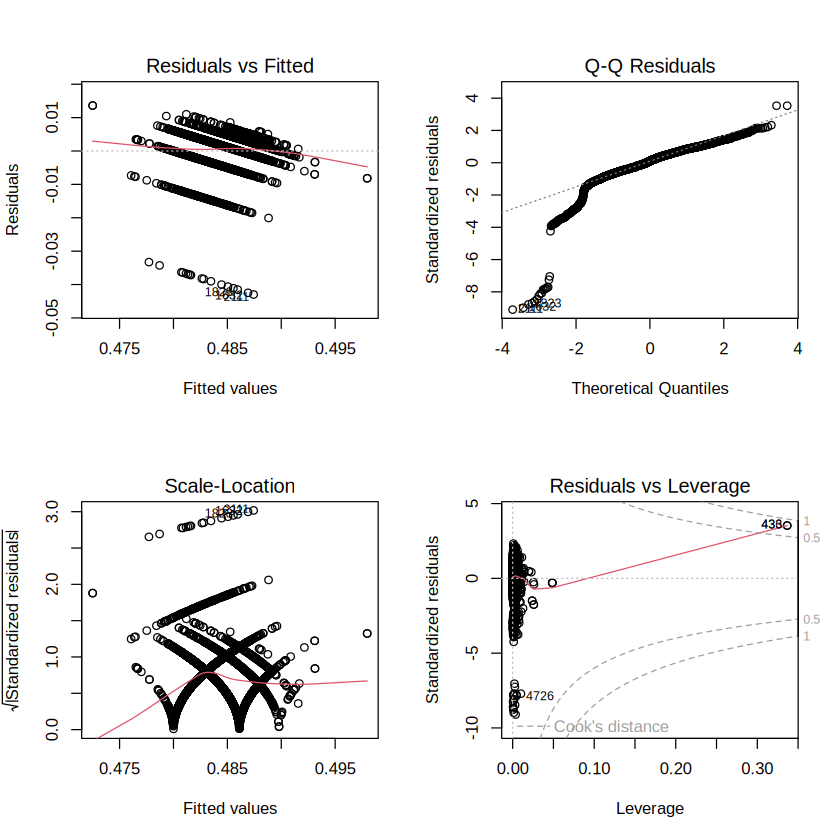

In [56]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_wqr)

#### Phân tích Residuals vs Fitted Plot

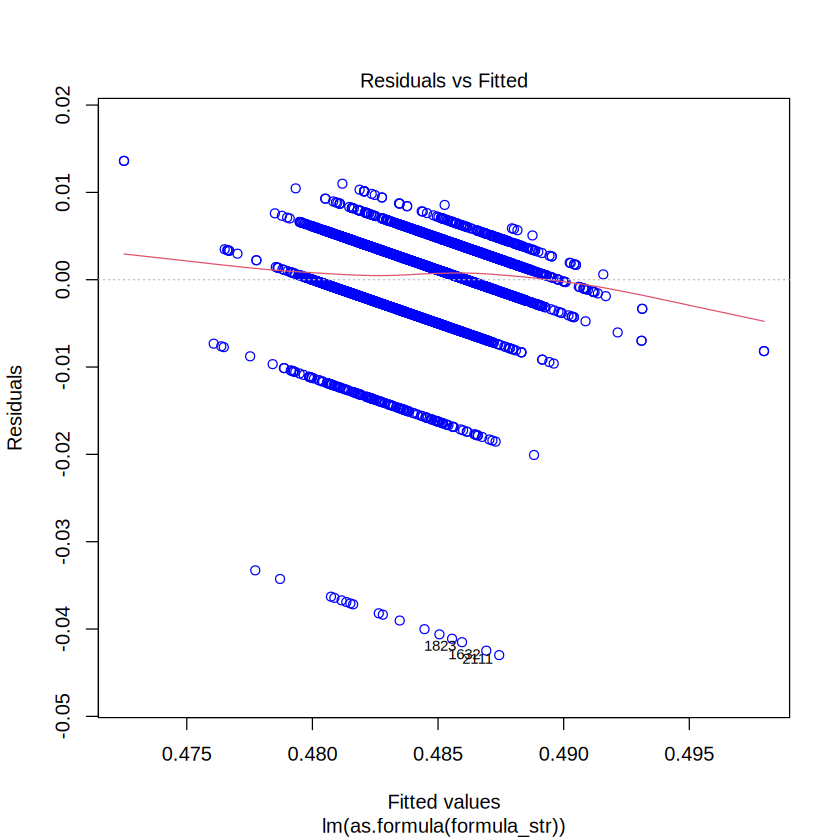

In [57]:
plot(best_model_wqr, which=1, col=c("blue")) # Residuals vs Fitted Plot

#### Phân tích Normal Q–Q (quantile-quantile) Plot


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.83609, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


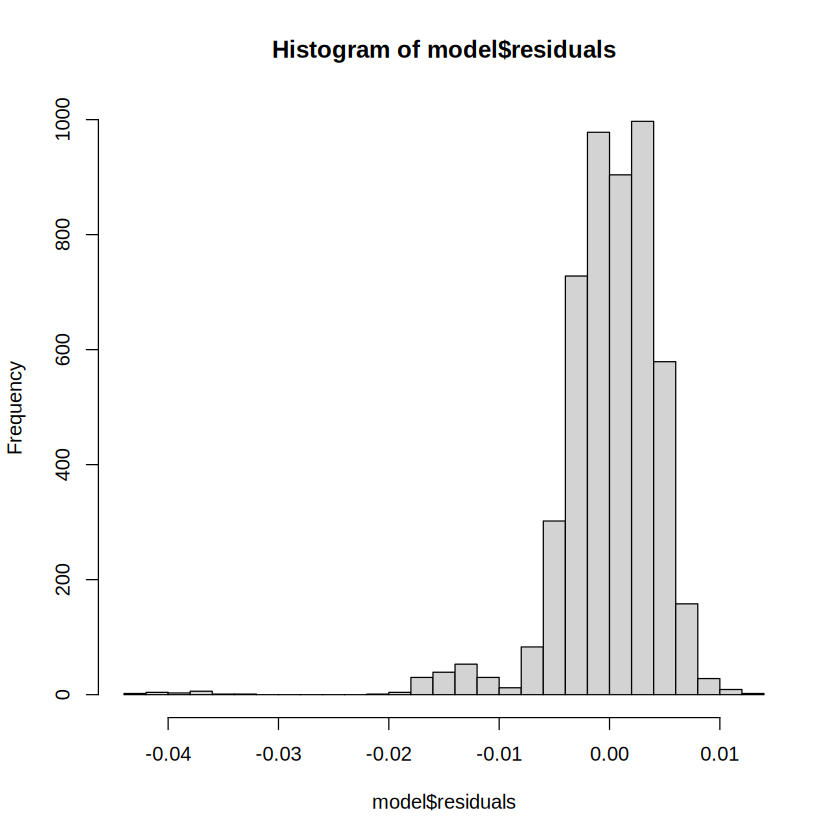

In [58]:
CheckNormal(model = best_model_wqr)

#### Phân tích Scale-Location


	studentized Breusch-Pagan test

data:  model
BP = 57.227, df = 7, p-value = 5.387e-10

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


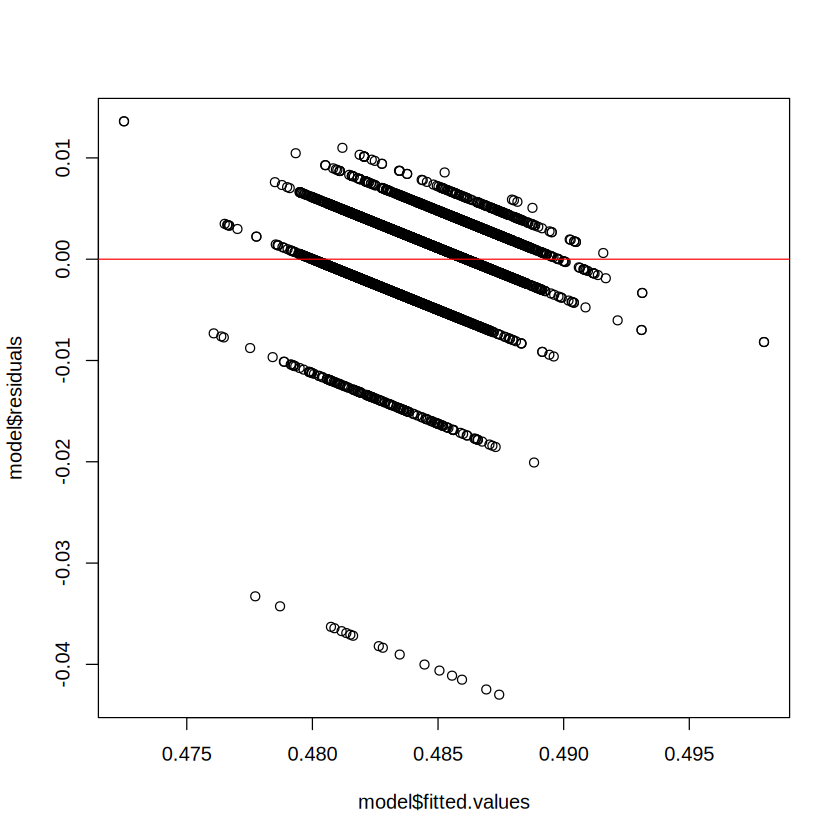

In [59]:
CheckHomos(best_model_wqr)

In [60]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.0008074283


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.016570 -0.002351  0.000209  0.002549  0.010449 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -4.954e-01  2.852e-02 -17.370  < 2e-16 ***
volatile.acidity    -1.373e-04  8.653e-06 -15.868  < 2e-16 ***
citric.acid          2.366e-03  7.707e-04   3.070  0.00215 ** 
residual.sugar       4.243e-03  4.083e-04  10.392  < 2e-16 ***
chlorides           -1.807e-06  2.562e-07  -7.054 1.99e-12 ***
free.sulfur.dioxide  2.345e-02  7.901e-03   2.967  0.00302 ** 
sulphates            4.105e-04  5.089e-05   8.067 9.03e-16 ***
alcohol              1.950e+00  5.605e-02  34.783  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003446 on 4748 degrees of freedom
Multiple R-squared:  0.3049,	Adjusted R-squared:  0.3039 
F-statistic: 297.6 on 7 and


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.97443, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


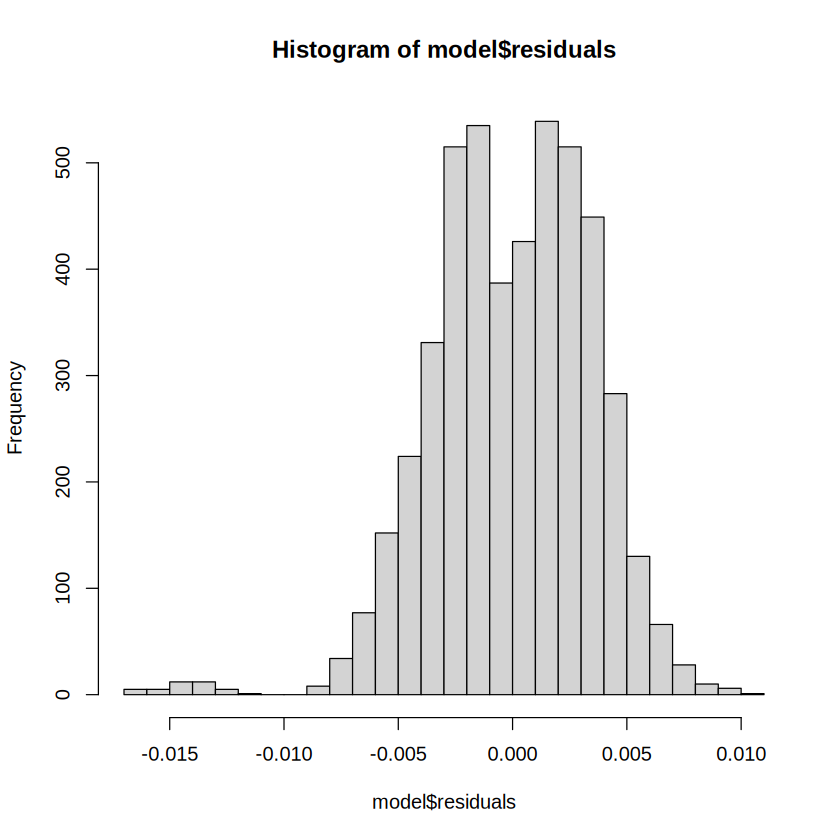


	studentized Breusch-Pagan test

data:  model
BP = 41.491, df = 7, p-value = 6.514e-07

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


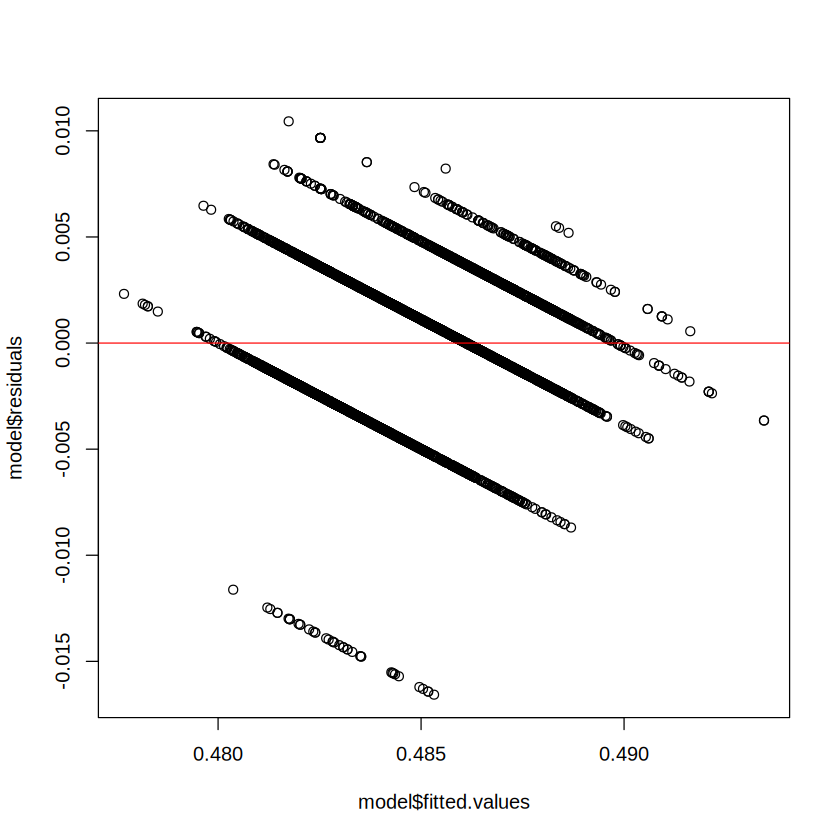

In [61]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.2)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_wqr.2))
CheckNormal(best_model_wqr.2)

# Breusch-Pagan Test
# bptest(best_model_wqr.2)
CheckHomos(best_model_wqr.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.042985 -0.002099  0.000519  0.002996  0.014023 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -5.215e-01  3.803e-02 -13.713  < 2e-16 ***
volatile.acidity    -1.402e-04  1.086e-05 -12.906  < 2e-16 ***
citric.acid          3.988e-03  1.034e-03   3.859 0.000116 ***
residual.sugar       4.945e-03  5.285e-04   9.357  < 2e-16 ***
chlorides           -1.668e-06  3.438e-07  -4.852 1.26e-06 ***
free.sulfur.dioxide  2.590e-02  5.557e-03   4.660 3.25e-06 ***
sulphates            5.130e-04  6.736e-05   7.615 3.16e-14 ***
alcohol              1.998e+00  7.613e-02  26.244  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004724 on 4745 degrees of freedom
Multiple R-squared:  0.2075,	Adjusted R-squared:  0.2063 
F-statistic: 177.5 on 7 and


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.83841, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


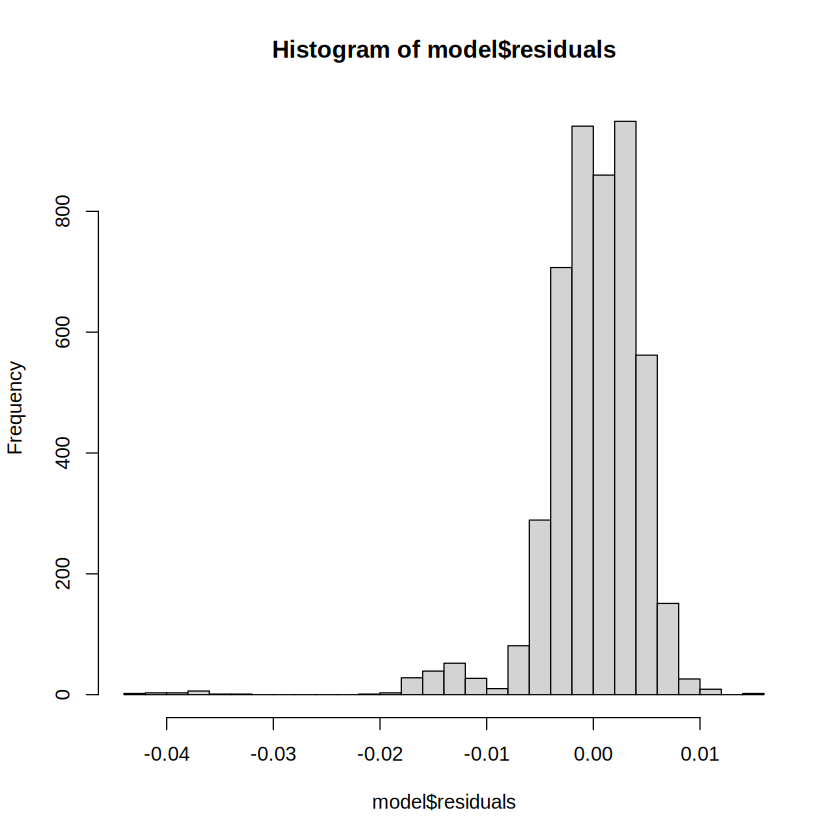


	studentized Breusch-Pagan test

data:  model
BP = 55.026, df = 7, p-value = 1.473e-09

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


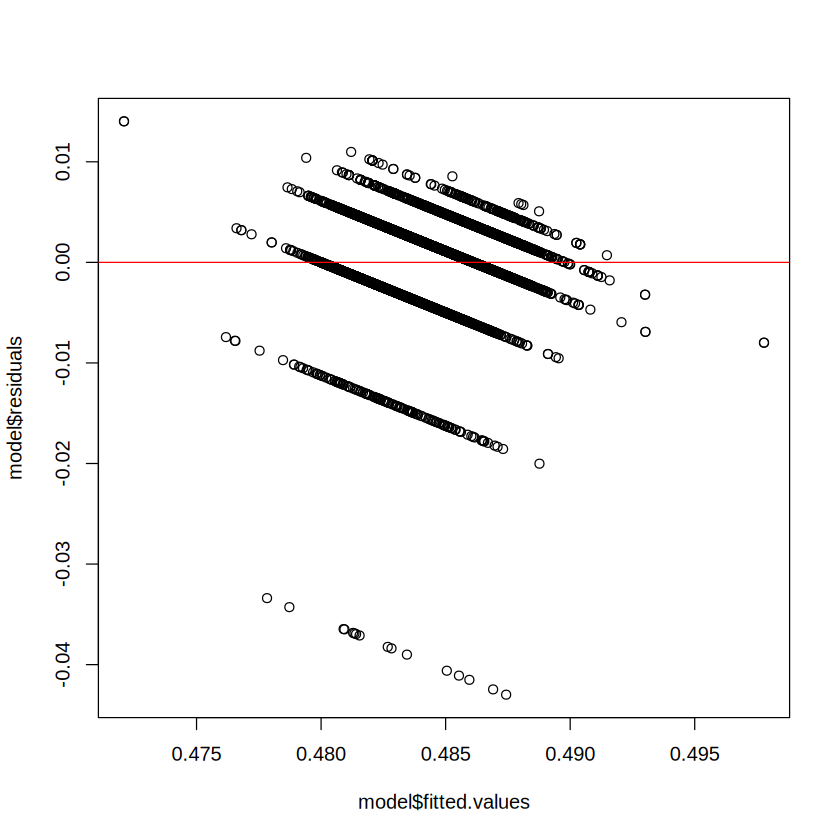

In [62]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.3)

# Shapiro-Wilk normality test
CheckNormal(best_model_wqr.3)

# Breusch-Pagan Test
CheckHomos(best_model_wqr.3)

## Đánh giá hiệu suất và dự đoán kết quả

[1] "MSE: 1.8e-05"
[1] "RMSE: 0.0042"
[1] "MAE: 0.002927"
[1] "Correlation: 0.428994"
[1] "R^2 between y_pred & y_true: 0.184036"


[1] 0.004199662

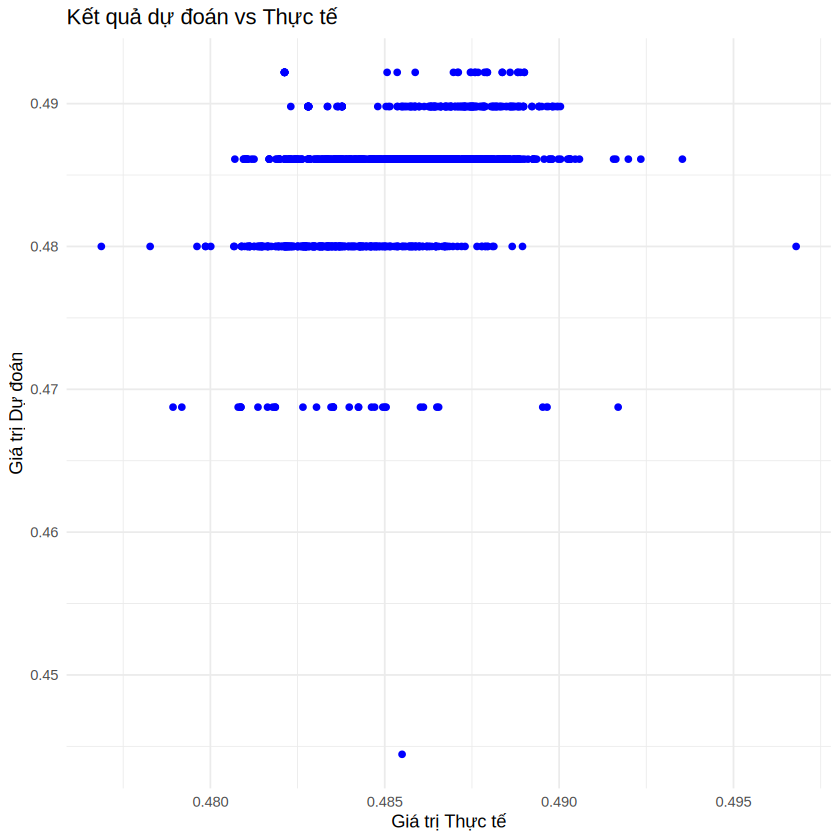

In [63]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_wqr.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$quality
)

metrics(results, test$quality)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$quality)